In [1]:
# from Tools.lambda_distribution import *
# from Tools.utility import get_lambdas_keras

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout
# from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
# from tensorflow.keras.optimizers import Adam, Nadam

import matplotlib.pyplot as plt
import matplotlib  as mpl
from tqdm import tqdm
import pickle
import lzma
import os

import numpy as np


# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.3
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

<ipython-input-1-230dcfbc90f3>:44: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [5]:
import wandb
from wandb.keras import WandbCallback

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="GLD_param_MPL"
)


config = wandb.config

wandb: Currently logged in as: bazvalya (bazvalya_team). Use `wandb login --relogin` to force relogin


In [4]:
config = wandb.config

In [5]:
config.learning_rate = 0.001
config.loss = 'mse'

config.early_stop_min_delta = 0.0001
config.early_stop_monitor = 'loss'
config.early_stop_patience = 300

config.lr_plan_monitor = 'loss'
config.lr_plan_factor = 0.1
config.lr_plan_patience = 100
config.lr_plan_min_delta=0.0001

config.activation ='sigmoid'
config.epochs = 1000
config.batchsize = 3000

In [6]:
# early stop
early_stop_clbk = tf.keras.callbacks.EarlyStopping(monitor=config.early_stop_monitor,
                                                   min_delta=config.early_stop_min_delta,
                                                   patience=config.early_stop_patience,
                                                   verbose=0, 
                                                   mode='auto',
                                                   restore_best_weights=True)

# learning rate regime
lr_plan = ReduceLROnPlateau(monitor=config.lr_plan_monitor,
                            factor=config.lr_plan_factor,
                            patience=config.lr_plan_patience,
                            verbose=0,
                            mode='auto',
                            min_delta=config.lr_plan_min_delta)

In [7]:
# choooosing lambdas class (?)
n_mesh_lambda = 350
class_name = 'Ib'
 
sample_generator = SampleLambdaMoments(n_mesh=n_mesh_lambda)
data_lambda = sample_generator.get_sample(class_name=class_name)
data_lambda.head()

Skewness  Kurtosis   Lambda3  Lambda4
0  1.038285  4.707865  0.500100    0.001
1  1.039851  4.711689  0.501532    0.001
2  1.041412  4.715113  0.502965    0.001
3  1.042970  4.719279  0.504397    0.001
4  1.044523  4.722661  0.505830    0.001

In [12]:
# choooosing lambdas class (?)
n_mesh_lambda = 350
class_names = ['Negative', 'Ia', 'Ib', 'Ic', 'II', 'III', 'IV', 'V']
 
frames = []
for class_name in class_names:
    sample_generator = SampleLambdaMoments(n_mesh=n_mesh_lambda)
    data_lambda = sample_generator.get_sample(class_name=class_name)
    frames.append(data_lambda)

In [13]:
all_data_lambda = pd.concat(frames)

In [14]:
features = ['Skewness','Kurtosis']
n_features = len(features)

labels = ['Lambda3', 'Lambda4']
n_labels = len(labels)

trainX = all_data_lambda[features]
trainY = all_data_lambda[labels]

# reshaping to correct nump array
trainX = trainX.values.reshape(-1,n_features)
trainY = trainY.values.reshape(-1,n_labels)

In [17]:
model_name = 'all_classes'

model = Sequential(name=f'MlpForLambda_{model_name}')

model.add(Dense(128, input_shape=(n_features,), activation=config.activation,name='Dense1')) 

model.add(Dense(64, activation=config.activation,name='Dense2')) 

model.add(Dense(16, activation=config.activation,name='Dense3')) 

model.add(Dense(n_labels, activation="linear", name='Output'))

model.compile(loss=config.loss, optimizer=Adam(learning_rate=config.learning_rate), )

model.summary()

Model: "MlpForLambda_all_classes"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense1 (Dense)              (None, 128)               384       
                                                                 
 Dense2 (Dense)              (None, 64)                8256      
                                                                 
 Dense3 (Dense)              (None, 16)                1040      
                                                                 
 Output (Dense)              (None, 2)                 34        
                                                                 
Total params: 9,714
Trainable params: 9,714
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(trainX, trainY, epochs=config.epochs, 
          batch_size=config.batchsize,  
          callbacks=[early_stop_clbk, lr_plan, WandbCallback()], verbose=0)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


test_lambda_fit (__main__.TestLambda) ... 

1/1 [==============================] - 0s 23ms/step


FAIL

FAIL: test_lambda_fit (__main__.TestLambda)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/hg/g0dmwys902d4l16w6vd0n3qr0000gn/T/ipykernel_86116/3046157047.py", line 8, in test_lambda_fit
    assert np.isclose(np.array(input_set), np.array([output_set]), 0, atol=0.1).all()
AssertionError

----------------------------------------------------------------------
Ran 1 test in 1.689s

FAILED (failures=1)


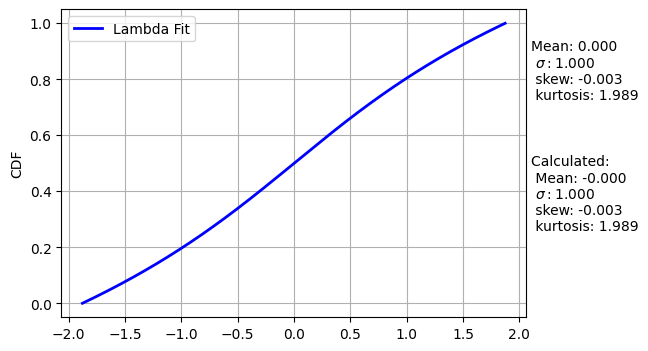

In [49]:
import unittest

class TestLambda(unittest.TestCase):
    
    def test_lambda_fit(self):
        input_set = [0,1,0,3]
        output_set = self.lambda_fit(input_set = input_set)
        assert np.isclose(np.array(input_set), np.array([output_set]), 0, atol=0.1).all()
        
    def lambda_fit(self, input_set):
        gld = GeneralizedLambdaDist(*get_lambdas_keras(*input_set, model))
        gld.dist_plot(n_sample=1000000)
        return gld.get_moments()

unittest.main(argv=[''], verbosity=2, exit=False)

# Estimate lambdas from moments

In [21]:
data = np.array([1, 2])
data = data.reshape(-1, 2)

In [50]:
def get_lambdas_keras(skewness, kurtosis, ml_model):
    '''
    A method to calculate lambda parameters for lambda distribution given the four first moments.
    The ml model (keras or tensor flow wrapper) is used to get skewness and kurtosis as features and
    estimate the expected lambda 3 and lambda 4. Lambda 1 and lambda 2 are then calculated mathematically.
    '''
    try:
        from Tools.lambda_distribution import beta_function
    except ImportError:
        from lambda_distribution import beta_function
    import numpy as np

    data = np.array([skewness, kurtosis])
    data = data.reshape(-1, 2)
    temp = ml_model.predict(data)
    lambda3 = temp[0][0]
    lambda4 = temp[0][1]

    return lambda3, lambda4



In [32]:
from Tools.lambda_distribution import *

In [40]:
get_lambdas_keras(2.5262618 ,  7.43578939,  model)

1/1 [==============================] - 0s 22ms/step


(-0.44150737, -0.33067304)

In [ ]:
0.08539696,  0.22410466

In [ ]:
# problem is the training set! What to do?

In [43]:
with open('data/Sobol/output_array/SC_pop100_results_all_array.pickle', 'rb') as f:
    results = pickle.load(f)

In [44]:
from scipy.stats import kurtosis, skew

In [45]:
skew_kurt_0_500 = np.zeros((100, 2))

for i in range(results[0][500].shape[1]):
    data = results[0][500][:, i]
    skew_kurt_0_500[i, 0] = skew(data, bias=True)
    skew_kurt_0_500[i, 1] = kurtosis(data, bias=True)

In [66]:
lambdas34 = np.zeros((100, 2))
for i, e in enumerate(skew_kurt_0_500):
    lambdas34[i][0], lambdas34[i][1] = get_lambdas_keras(e[0], e[1], model)

1/1 [==============================] - 0s 21ms/step


In [75]:
start = time.time()
lambdas_array = []

for i in tqdm.tqdm(range(results[0][500].shape[1])):
    data=results[0][500][:, i]
    
    with contextlib.redirect_stdout(None):
        param_ML = gld.fit_ML(data,[0.1,0.1], method = 'LMM', disp_fit = False, 
                              maxiter=1000, maxfun=1000)
        lambdas_array.append(param_ML)
end = time.time()
print(f"Done! Took {end - start}")

100%|█████████████████████████████████████████| 100/100 [27:20<00:00, 16.40s/it]

Done! Took 1640.2174098491669


In [77]:
lambdas_ML = np.asarray(lambdas_array)

In [92]:
lambdas_array_MM = []
for i in tqdm.tqdm(range(results[0][500].shape[1])):
    data=results[0][500][:, i]
        
    with contextlib.redirect_stdout(None):
        params_MM = gld.fit_MM(data, [0.5, 1], 
                               disp_fit = False, maxiter=1000, maxfun=1000)
        lambdas_array_MM.append(params_MM)

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.28it/s]


In [93]:
lambdas_MM = np.asarray(lambdas_array_MM)

In [108]:
lambdas_array_PM = []
for i in tqdm.tqdm(range(results[0][500].shape[1])):
    data=results[0][500][:, i]
        
    with contextlib.redirect_stdout(None):
        param_PM = gld.fit_PM(data, [0.1,0.1], disp_fit = False, maxiter=1000, maxfun=1000)
        
        lambdas_array_PM.append(param_PM)


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 153.27it/s]


In [109]:
lambdas_PM = np.asarray(lambdas_array_PM)

In [136]:
lambdas_array_MPS = []
for i in tqdm.tqdm(range(results[0][500].shape[1])):
    data=results[0][500][:, i]
        
    with contextlib.redirect_stdout(None):
        param_MPS = gld.fit_MPS(data,[0.1,0.1], method = 'LMM', disp_fit = False, maxiter=1000, maxfun=1000)
        lambdas_array_MPS.append(param_MPS)


100%|█████████████████████████████████████████| 100/100 [16:21<00:00,  9.82s/it]


In [137]:
lambdas_MPS = np.asarray(lambdas_array_MPS)

In [141]:
lambdas_array_star = []
for i in tqdm.tqdm(range(results[0][500].shape[1])):
    data=results[0][500][:, i]
        
    with contextlib.redirect_stdout(None):
        param_star = gld.fit_starship(data,[0.1,0.1], method = 'LMM', 
                                      disp_fit = False, maxiter=1000, maxfun=1000)
        lambdas_array_star.append(param_star)

100%|█████████████████████████████████████████| 100/100 [16:48<00:00, 10.08s/it]


In [142]:
lambdas_star = np.asarray(lambdas_array_star)

In [186]:
from scipy import stats

In [209]:
def cdf(x):
    """Auxiliary function for GoF test."""  
    print(x)
    return gld.CDF_num(x, param_LMM)

In [304]:
ks_ = []
lambdas_array_LMM = []
for i in tqdm.tqdm(range(results[0][500].shape[1])):
    data=results[0][500][:, i]
        
    with contextlib.redirect_stdout(None):
        param_LMM = gld.fit_LMM(data,[0.5,0.5], disp_fit = False, maxiter=1000, maxfun=1000)
        ks = stats.kstest(data, cdf)
        ks_.append(ks)
#         gld.plot_cdf(param_LMM, data)
        
        lambdas_array_LMM.append(param_LMM)

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 18.79it/s]


In [305]:
lambdas_LMM = np.asarray(lambdas_array_LMM)

In [278]:
if not os.path.exists('data/GLD'):
    os.makedirs('data/GLD')

# Charles: start here LMM GLD

In [6]:
DATA_DIR = "./data/output_directory"

In [7]:
W_arrays = {f'{i}':{} for i in range(10)}

In [33]:
for f in tqdm(os.listdir(DATA_DIR)):
    data = pickle.load(lzma.open(f"./data/output_directory/{f}"))
    seed, param = f.split(".")[0].split("_")
    W_arrays[seed][param] = data["W"]

100%|██████████| 92160/92160 [1:04:56<00:00, 23.65it/s]


In [49]:
with open("./data/sobol/W_arrays.pickle", "wb") as f:
    pickle.dump(W_arrays, f)

In [50]:
W_ALL = np.zeros((10, 9216, 1250, 51), dtype=np.float16)
for seed_idx, seed in enumerate(W_arrays):
    param_W = W_arrays[seed]
    keys = list(param_W.keys())
    sorted_param_keys = sorted([int(x) for x in keys])
    for k_idx, k in tqdm(enumerate(sorted_param_keys)):
        W_ALL[seed_idx][k_idx] = param_W[str(k)].T

9216it [00:24, 368.66it/s] 
9216it [00:23, 391.95it/s] 
9216it [00:39, 234.98it/s] 
9216it [00:24, 382.51it/s] 
9216it [00:22, 418.56it/s] 
9216it [00:23, 399.28it/s] 
9216it [00:20, 446.77it/s] 
9216it [00:23, 387.19it/s] 
9216it [00:19, 483.74it/s] 
9216it [00:24, 370.10it/s] 


In [51]:
with open("./data/sobol/10_9216_1250_51.pickle", "wb") as f:
    pickle.dump(W_ALL, f)

In [301]:
with open('data/Sobol/output_array/10_9216_1250_51.pickle', 'rb') as f:
    results = pickle.load(f)

In [302]:
results.shape

(10, 5120, 100, 100)

In [74]:
from gldpy import GLD
gld = GLD('FMKL')

import tqdm
import contextlib
import time

In [279]:
with open('data/Sobol/output_array/SC_pop100_results_all_array.pickle', 'rb') as f:
    results = pickle.load(f)

n_runs = results.shape[0]
n_param_combos = results.shape[1]
n_steps = results.shape[3]
n_lambdas = 4


if not os.path.exists('data/GLD/pop100_LMM.pickle'):
    lambdas_LMM = np.zeros((n_runs, n_param_combos, n_steps, n_lambdas))

    for run in range(n_runs):
        print('Run:', run)
        for param_id in tqdm.tqdm(range(n_param_combos)):
            for step in range(n_steps):
                data = results[run][param_id][:, step]
                with contextlib.redirect_stdout(None):
                    param_LMM = gld.fit_LMM(data,[0.5,0.5], disp_fit = False, maxiter=1000, maxfun=1000)

                    lambdas_LMM[run][param_id][step] = param_LMM
                    
    with open('data/GLD/pop100_LMM.pickle', 'wb') as f:
        pickle.dump(lambdas_LMM, f)    
else: 
    with open('data/GLD/pop100_LMM.pickle', 'rb') as f:
        lambdas_LMM_result = pickle.load(f)
    
            

In [9]:
lambdas_LMM = np.zeros((10, 9216, 51, 4))
for RUN in range(10):
    k=0
    run_results = pickle.load(lzma.open(f"./data/sobol/concat_W_arrays/{RUN}_9216_1250_51.pkl.lzma"))
    for param_id in range(9216):
        for step in range(51):
            lambdas_LMM[RUN][param_id][step] = run_results[k]
            k+=1

ValueError: could not broadcast input array from shape (1250,51) into shape (4,)

In [15]:
run_results.shape

(9216, 1250, 51)

In [ ]:
with open('./data/LMM_results.pickle', 'wb') as f:
    pickle.dump(lambdas_LMM, f)  

In [ ]:
lambdas_LMM_result[0, :, :, 2].shape

In [300]:
lambdas_LMM_result[0, :, :, 2].shape

(5120, 100)

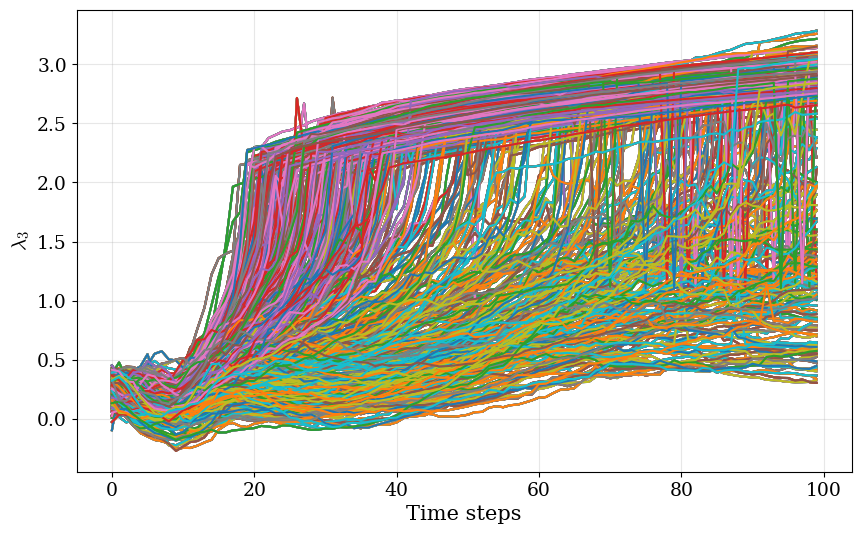

In [299]:
for i in range(5120):
    plt.plot(lambdas_LMM_result[2][i][:, 2])
plt.xlabel('Time steps')
plt.ylabel(r'$\lambda_3$')
plt.show()

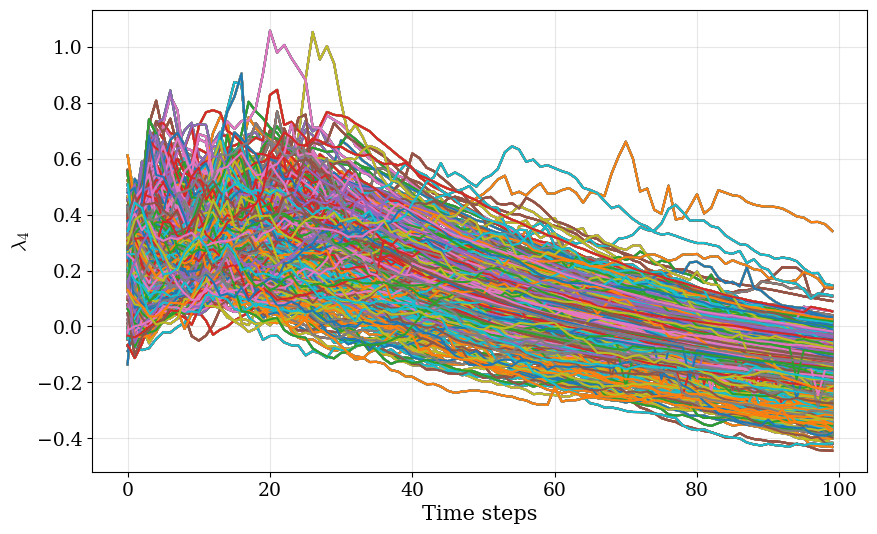

In [298]:
for i in range(5120):
    plt.plot(lambdas_LMM_result[2][i][:, 3])
plt.xlabel('Time steps')
plt.ylabel(r'$\lambda_4$')
plt.show()

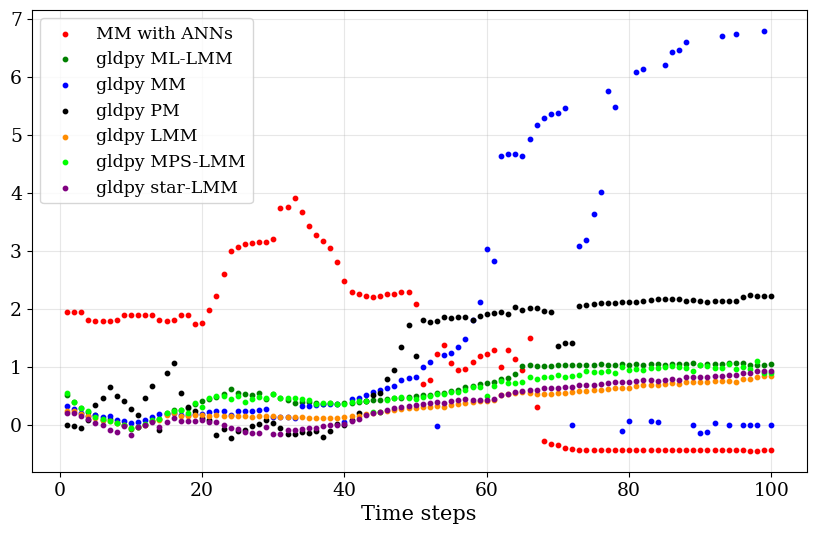

In [308]:
plt.scatter(np.linspace(1, 100, 100), lambdas34[:, 0],  c='r', s=10, label='MM with ANNs')
plt.scatter(np.linspace(1, 100, 100), lambdas_ML[:, 2], c='g', s=10, label='gldpy ML-LMM')
plt.scatter(np.linspace(1, 100, 100), lambdas_MM[:, 2], c='b', s=10, label='gldpy MM')
plt.scatter(np.linspace(1, 100, 100), lambdas_PM[:, 2], c='k', s=10,  label='gldpy PM')
plt.scatter(np.linspace(1, 100, 100), lambdas_LMM[:, 2], c='darkorange', s=10, label='gldpy LMM')
plt.scatter(np.linspace(1, 100, 100), lambdas_MPS[:, 2], c='lime', s=10, label='gldpy MPS-LMM')
plt.scatter(np.linspace(1, 100, 100), lambdas_star[:, 2], c='purple', s=10, label='gldpy star-LMM')
plt.legend()
plt.xlabel('Time steps')
plt.show()

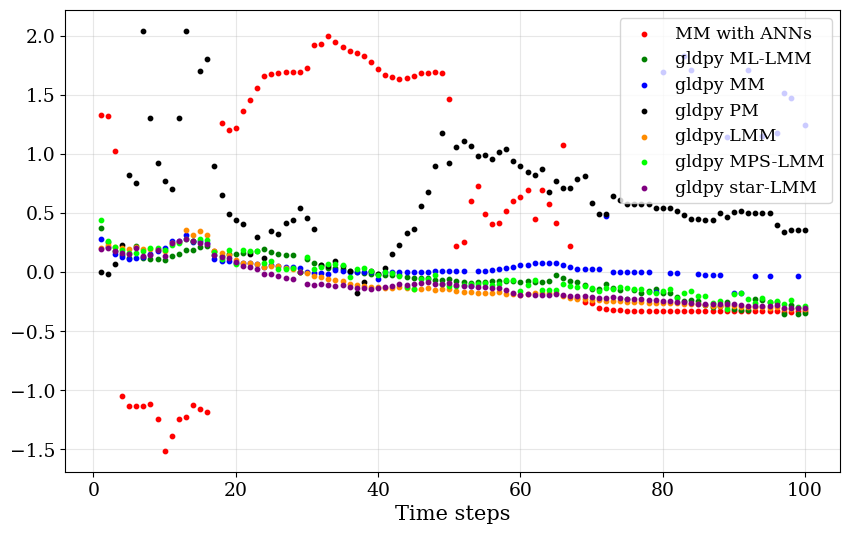

In [309]:
plt.scatter(np.linspace(1, 100, 100), lambdas34[:, 1],  c='r', s=10, label='MM with ANNs')
plt.scatter(np.linspace(1, 100, 100), lambdas_ML[:, 3], c='g', s=10, label='gldpy ML-LMM')
plt.scatter(np.linspace(1, 100, 100), lambdas_MM[:, 3], c='b', s=10, label='gldpy MM')
plt.scatter(np.linspace(1, 100, 100), lambdas_PM[:, 3], c='k', s=10,  label='gldpy PM')
plt.scatter(np.linspace(1, 100, 100), lambdas_LMM[:, 3], c='darkorange', s=10, label='gldpy LMM')
plt.scatter(np.linspace(1, 100, 100), lambdas_MPS[:, 3], c='lime', s=10, label='gldpy MPS-LMM')
plt.scatter(np.linspace(1, 100, 100), lambdas_star[:, 3], c='purple', s=10, label='gldpy star-LMM')
plt.legend()
plt.xlabel('Time steps')
plt.show()

In [ ]:
with open('data/Sobol/output_array/SC_pop320_results_all_array.pickle', 'rb') as f:
    results_pop320 = pickle.load(f)
    
n_runs = results_pop320.shape[0]
n_param_combos = results_pop320.shape[1]
n_steps = results_pop320.shape[3]
n_lambdas = 4

lambdas_LMM_pop320 = np.zeros((n_runs, n_param_combos, n_steps, n_lambdas))

for run in range(n_runs):
    print('Run:', run)
    for param_id in tqdm.tqdm(range(n_param_combos)):
        for step in range(n_steps):
            data = results_pop320[run][param_id][:, step]
            with contextlib.redirect_stdout(None):
                param_LMM = gld.fit_LMM(data,[0.5,0.5], disp_fit = False, maxiter=1000, maxfun=1000)
                
                lambdas_LMM_pop320[run][param_id][step] = param_LMM


if not os.path.exists('data/GLD/pop320_LMM.pickle'):
    with open('data/GLD/pop320_LMM.pickle', 'wb') as f:
        pickle.dump(lambdas_LMM_pop320, f)    
else:
    with open('data/GLD/pop320_LMM.pickle', 'rb') as f:
        lambdas_LMM_pop320_result = pickle.load(f)

# GLD fit $\rightarrow$ GDMaps PCE on $\lambda_3$ and $\lambda_4$ - skip

In [4]:
import sys
sys.path.append('./GDMaps_PCE/')
from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps
from GDMaps_PCE_GSA import *

from UQpy.distributions import Normal, Uniform, JointIndependent

import itertools as it


In [6]:
def plot_dm_parsim_coord(coord, g):
    
    comb1 = list(it.combinations(list(coord), 2))
    comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))
    
#     print(f'comb1: {comb1}')
#     print(f'comb2: {comb2}')

    # Plot first three plots
    if coord.shape[0] > 2:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
        
        for i in range(len(comb1)):
            ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            ax[i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            ax[i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            ax[i].grid('True')
            ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        plt.show()

In [7]:
with open('data/GLD/pop100_LMM.pickle', 'rb') as f:
    lambdas_LMM_result = pickle.load(f)

In [8]:
pop100_lambda3 = lambdas_LMM_result[:, :, :, 2]

In [9]:
n2 = pop100_lambda3.shape[2]

reshaped_pop100_lambda3 = pop100_lambda3.reshape(10, 5120, int(np.sqrt(n2)), int(np.sqrt(n2)))

In [7]:
ranks = []

num_runs = 10

for run in range(num_runs):
    data_all = reshaped_pop100_lambda3[run]
    
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')

Ranks: 
 [[   10 51200]]


In [10]:
# Charles: Important for PCE x

param_names = {
    'Heterogeneity_endowment': r'$H_e$',
    'Heterogeneity_metabolism': r'$H_m$', 
    'Heterogeneity_vision': r'$H_v$'
}

problem = {
    'h_e': [float, [0.01, 1]],
    'h_m': [float, [0.01, 1]],
    'h_v': [float, [0.01, 1]],
}

problem_sampler = {
    'num_vars': len(problem),
    'names': [key for key in sorted(problem.keys())],
    'bounds': [problem[key][1] for key in sorted(problem.keys())]
}

saltelli_1024 = np.loadtxt('data/Sobol/saltellisample_1024')

x = saltelli_1024  #important
print(f'Problem bounds: {problem_sampler["bounds"]}')

pdf1 = Uniform(loc=0.01, scale=0.99)  
pdf2 = Uniform(loc=0.01, scale=0.99)  
pdf3 = Uniform(loc=0.01, scale=0.99)  

margs = [pdf1, pdf2, pdf3]
joint = JointIndependent(marginals=margs) # important - dist_obj in PCE

Problem bounds: [[0.01, 1], [0.01, 1], [0.01, 1]]


In [21]:
data = reshaped_pop100_lambda3[0]


# Perform GDMAps
start_time = time.time()
g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                         n_evecs=20,
                                                         n_keep=3, 
                                                         p=5,
                                                         parsim=True).get() 

print("--- GDMaps - %s seconds ---" % (time.time() - start_time))


Running with parsimonious representation
--- GDMaps - 647.109866142273 seconds ---


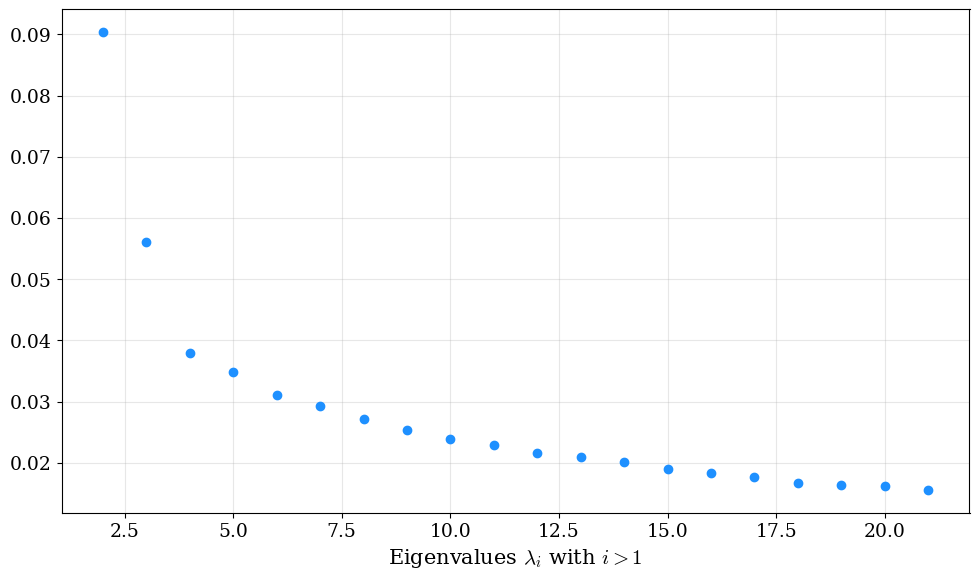

In [26]:
plt.scatter(np.arange(2, len(evals)+1, 1), evals[1:], c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
plt.tight_layout()
plt.show()

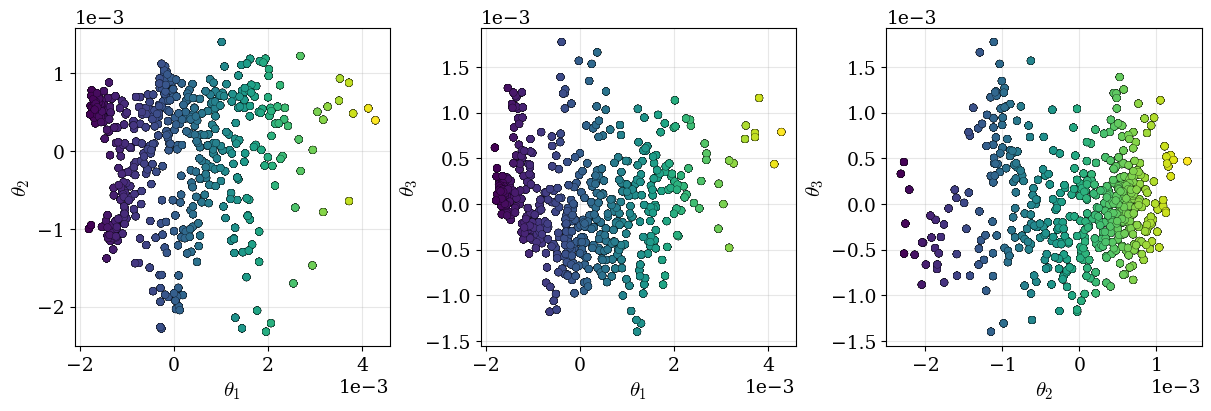

In [27]:
plot_dm_parsim_coord(coord, g)

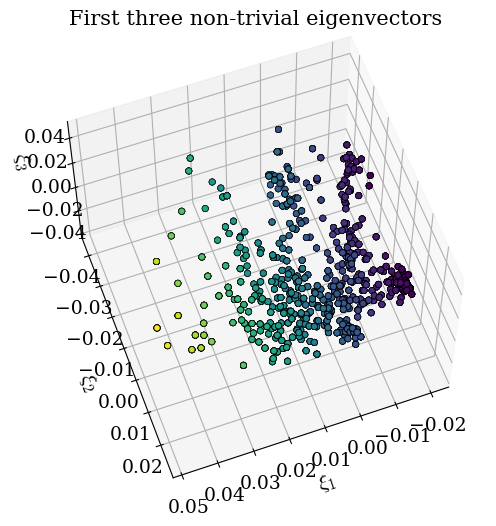

In [30]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(evecs[:, 1], evecs[:, 2], evecs[:, 3],
           cmap='viridis', s=20,
           c=evecs[:, 1],
           edgecolors='k', 
           linewidth=0.5)
ax.set(xlabel=r'$\xi_{1}$', 
       ylabel=r'$\xi_{2}$', 
       zlabel=r'$\xi_{3}$', 
       title='First three non-trivial eigenvectors')
ax.view_init(60, 70)
plt.show()

In [49]:
data = reshaped_pop100_lambda3[0]

# Perform GDMAps
start_time = time.time()
g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                         n_evecs=20,
                                                         n_keep=3, 
                                                         p=3,
                                                         parsim=True).get() 

print("--- GDMaps - %s seconds ---" % (time.time() - start_time))

Running with parsimonious representation
--- GDMaps - 672.3942110538483 seconds ---


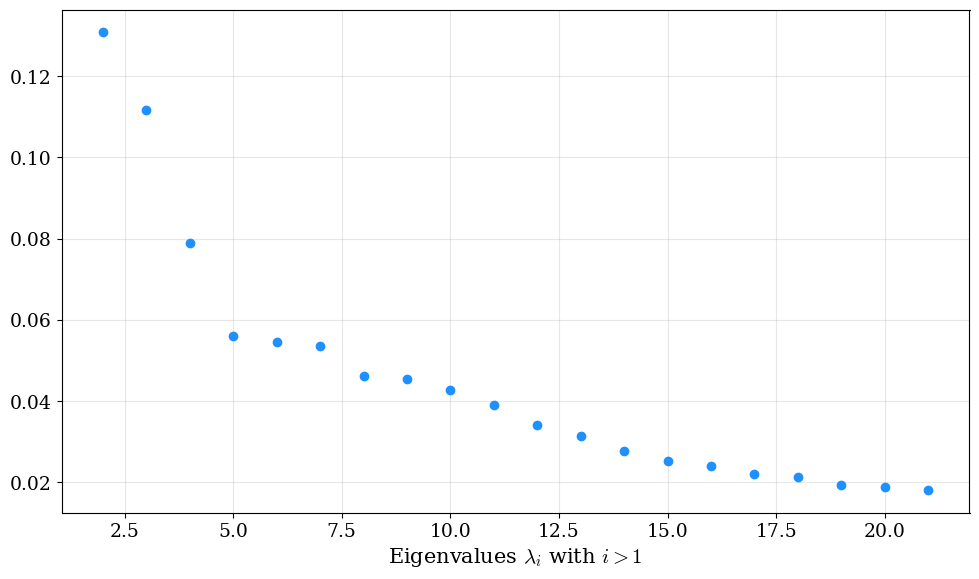

In [50]:
plt.scatter(np.arange(2, len(evals)+1, 1), evals[1:], c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
plt.tight_layout()
plt.show()

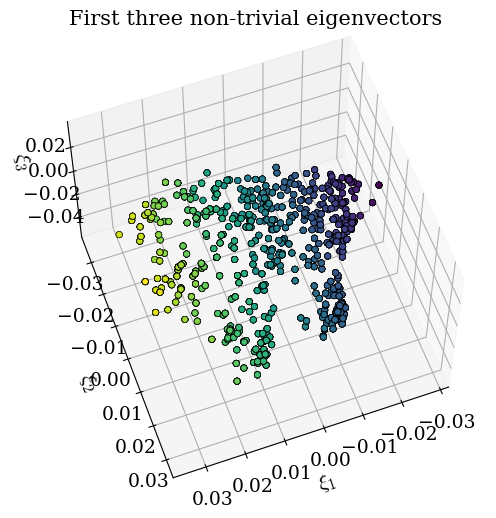

In [51]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(evecs[:, 1], evecs[:, 2], evecs[:, 3],
           cmap='viridis', s=20,
           c=evecs[:, 1],
           edgecolors='k', 
           linewidth=0.5)
ax.set(xlabel=r'$\xi_{1}$', 
       ylabel=r'$\xi_{2}$', 
       zlabel=r'$\xi_{3}$', 
       title='First three non-trivial eigenvectors')
ax.view_init(60, 70)
plt.show()

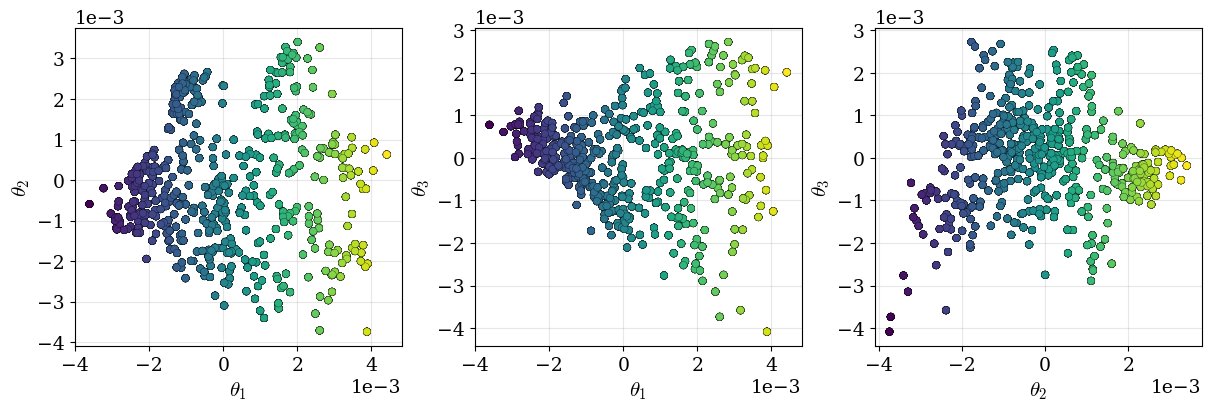

In [52]:
plot_dm_parsim_coord(coord, g)

In [72]:
data = reshaped_pop100_lambda3[0]

# Perform GDMAps
start_time = time.time()
g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                         n_evecs=20,
                                                         n_keep=3, 
                                                         p=7,
                                                         parsim=True).get() 

print("--- GDMaps - %s seconds ---" % (time.time() - start_time))

Running with parsimonious representation
--- GDMaps - 637.6166868209839 seconds ---


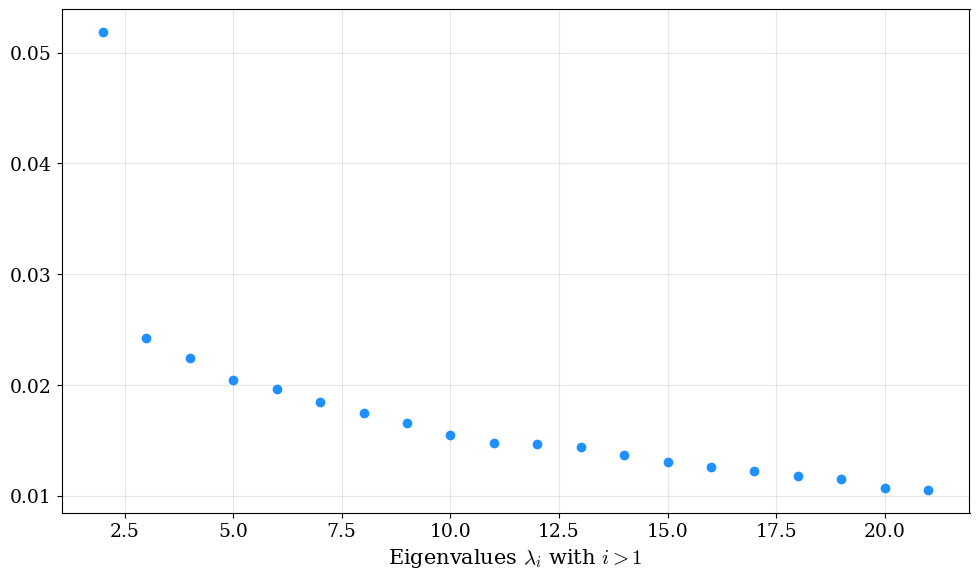

In [73]:
plt.scatter(np.arange(2, len(evals)+1, 1), evals[1:], c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
plt.tight_layout()
plt.show()

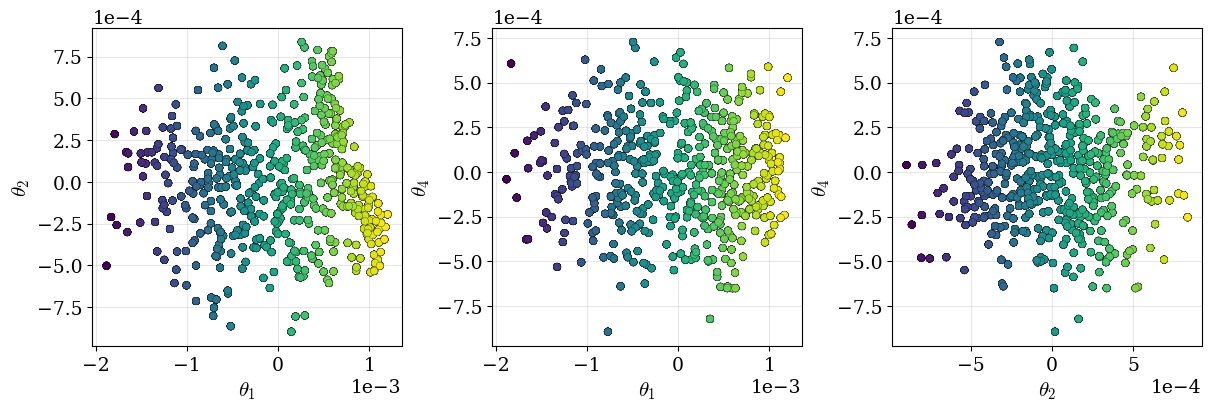

In [74]:
plot_dm_parsim_coord(coord, g)

In [87]:
data = reshaped_pop100_lambda3[0]

# Perform GDMAps
start_time = time.time()
g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                         n_evecs=10,
                                                         n_keep=3, 
                                                         p=6,
                                                         parsim=True).get() 

print("--- GDMaps - %s seconds ---" % (time.time() - start_time))

Running with parsimonious representation
--- GDMaps - 375.6187391281128 seconds ---


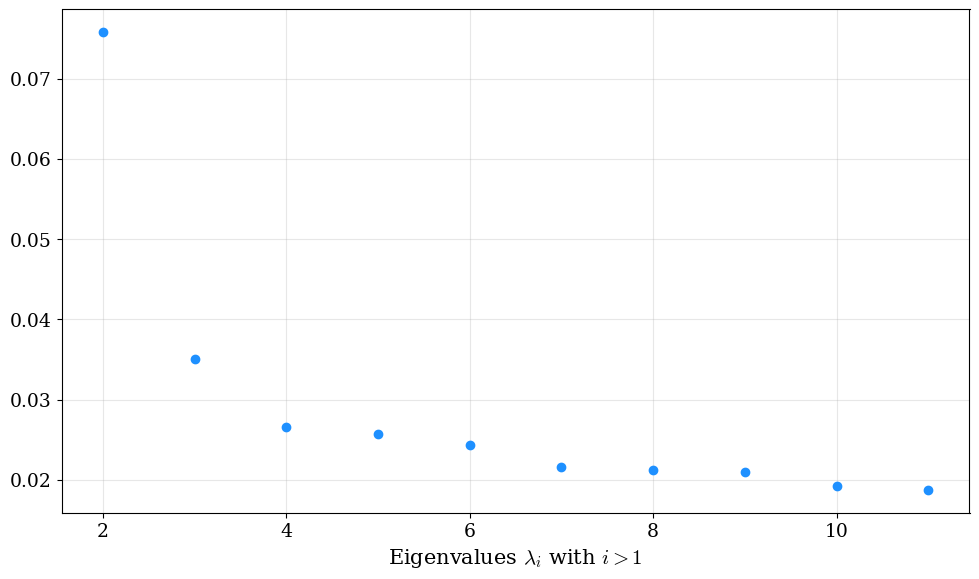

In [88]:
plt.scatter(np.arange(2, len(evals)+1, 1), evals[1:], c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
plt.tight_layout()
plt.show()

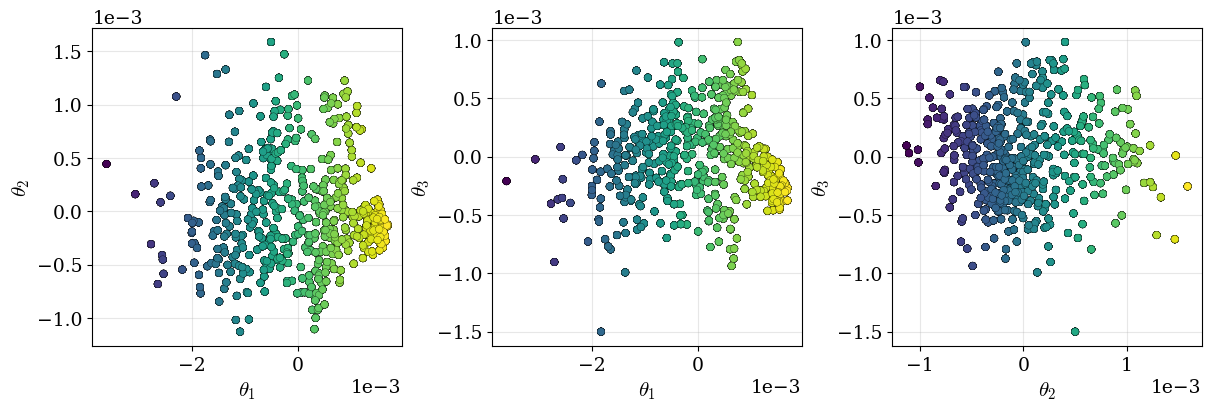

In [89]:
plot_dm_parsim_coord(coord, g)

Size of the full set of PCE basis: 20
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
[ 0.00136234 -0.00018079 -0.00020173]
[ 2.29748480e-05 -1.23705648e-05  1.82389832e-05]


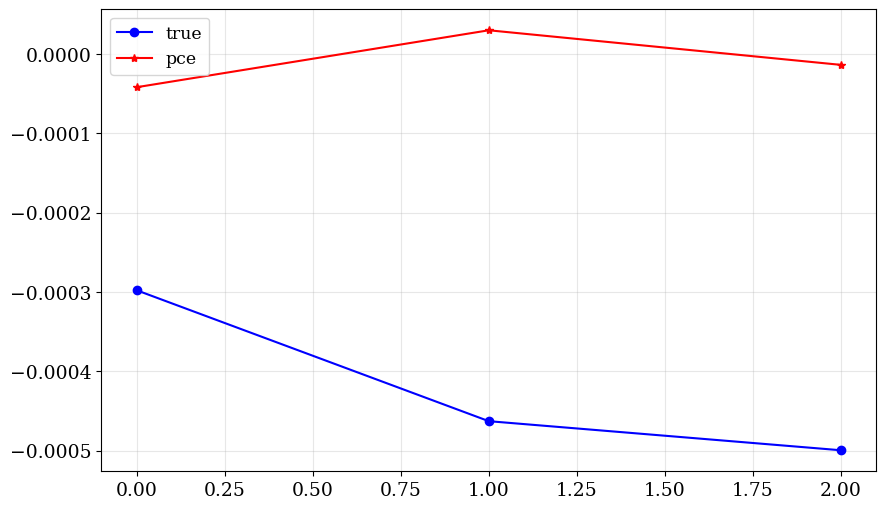

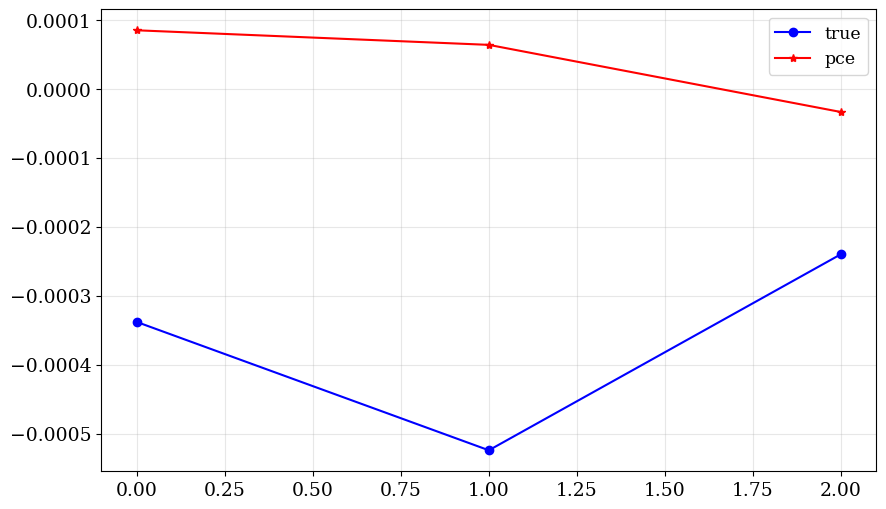

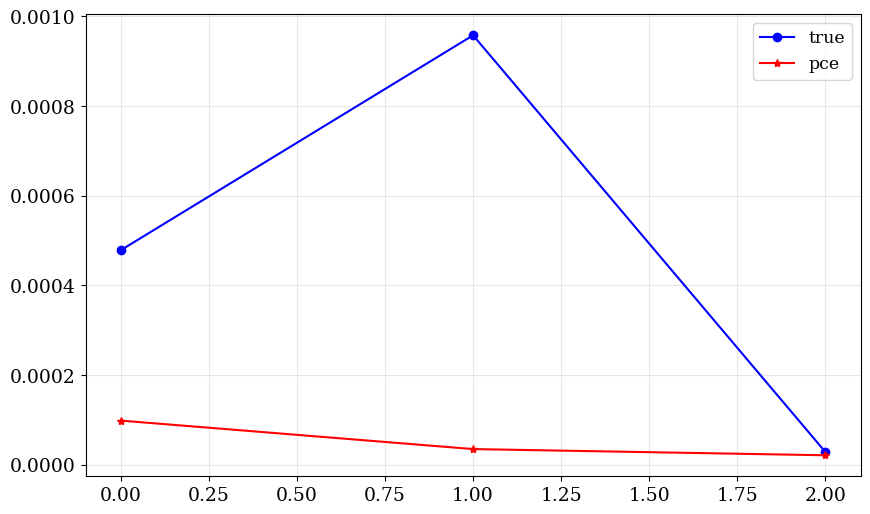

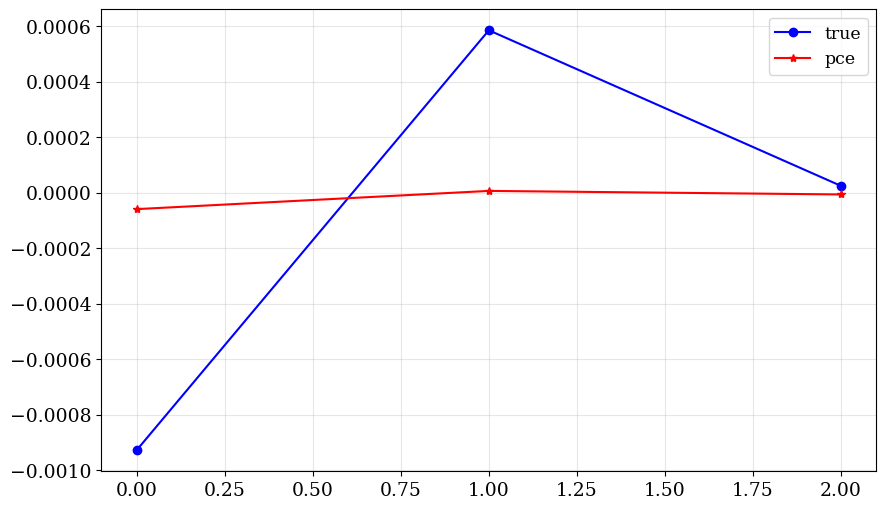

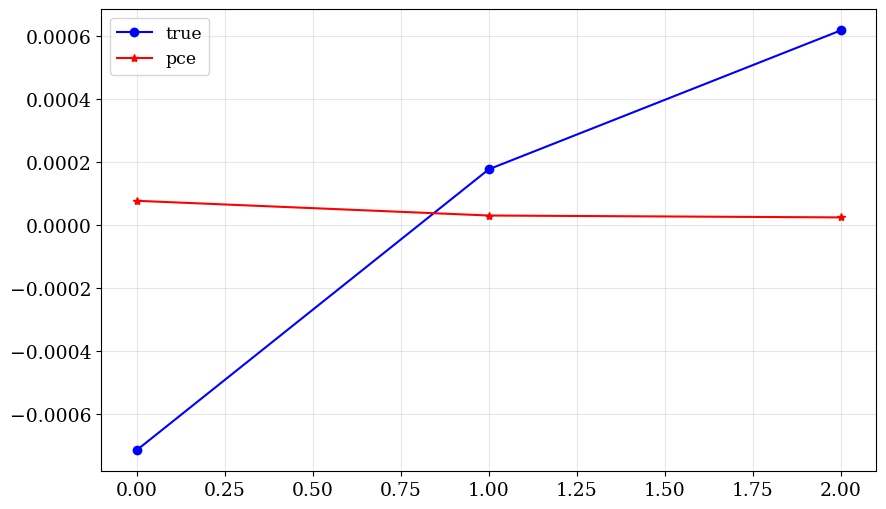

Error of PCE: [0.9992442 1.0047242 0.9969055]
--- Surrogate - 2.0730199813842773 seconds ---


In [90]:
x = saltelli_1024

# Perform PCE on the manifold
start_time = time.time()

pce, error = PceModel(x=x, 
                      g=g, 
                      dist_obj=joint, 
                      max_degree=3, 
                      regression='OLS',
                      verbose=True).get()

print('Error of PCE:', error)
print("--- Surrogate - %s seconds ---" % (time.time() - start_time))

In [91]:
print('LOO-error: ', pce.leaveoneout_error())

LOO-error:  [1.0011333 1.0055317 1.0089742]


In [95]:
pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()

print('First-order Sobol indices:')
print(pce_fo_si)
print('Total-order Sobol indices:')
print(pce_to_si)

First-order Sobol indices:
[[0.29241255 0.18553408 0.13606456]
 [0.36689227 0.13287382 0.13682013]
 [0.02894338 0.06371335 0.07732484]]
Total-order Sobol indices:
[[0.50612332 0.5400527  0.73265361]
 [0.61130522 0.65074461 0.75851927]
 [0.20875898 0.63875907 0.37258775]]


Size of the full set of PCE basis: 10
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
[0.00059406 0.00057863 0.00031192]
[ 8.39166881e-06 -8.56604069e-06 -5.66645869e-06]


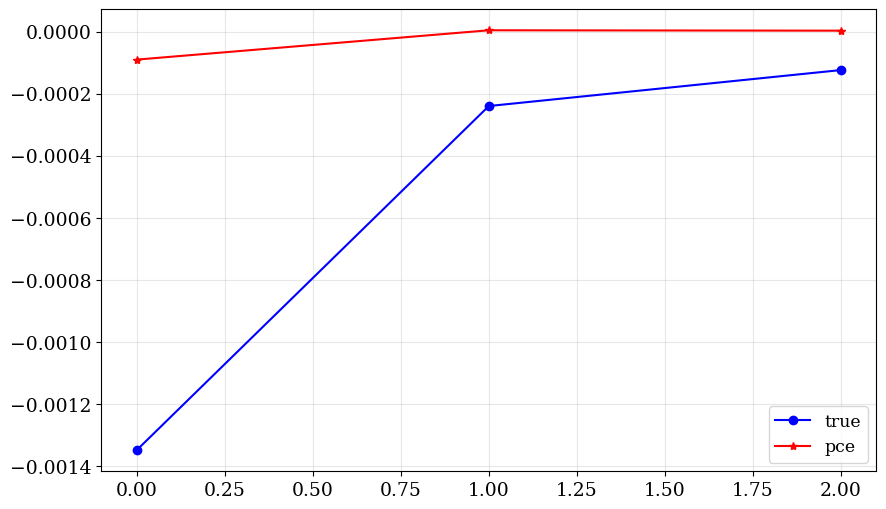

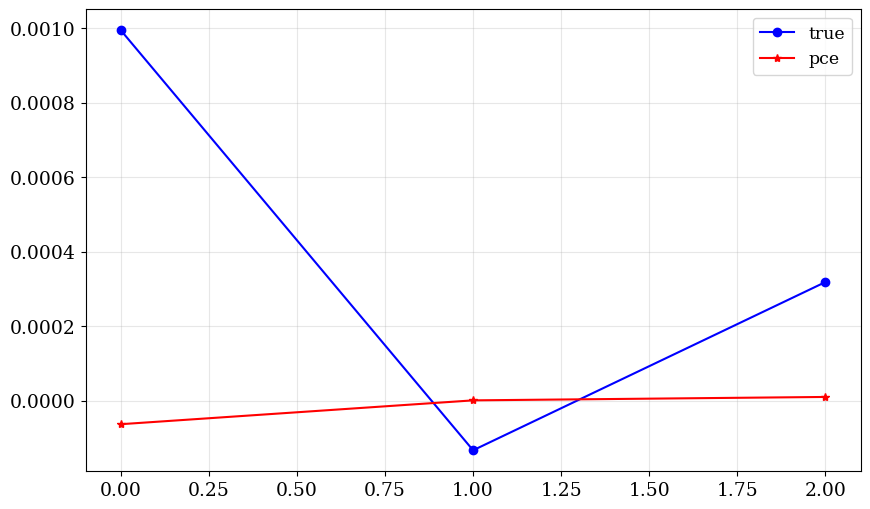

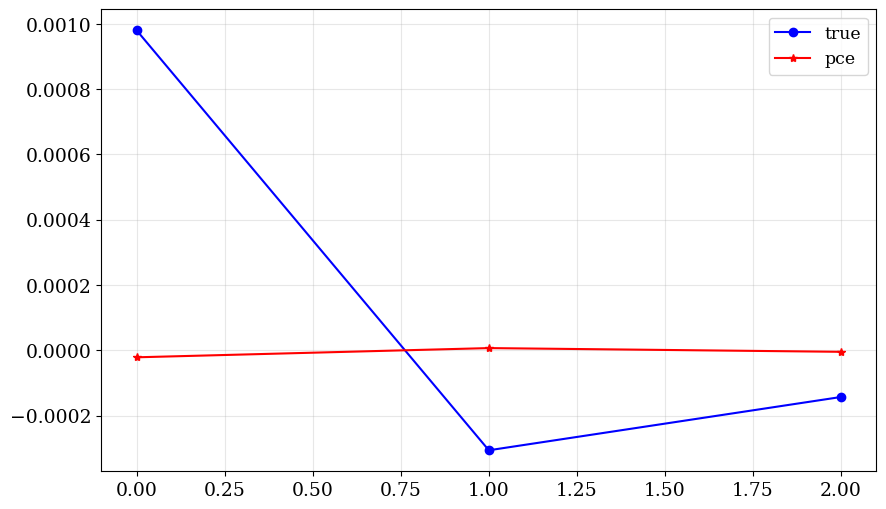

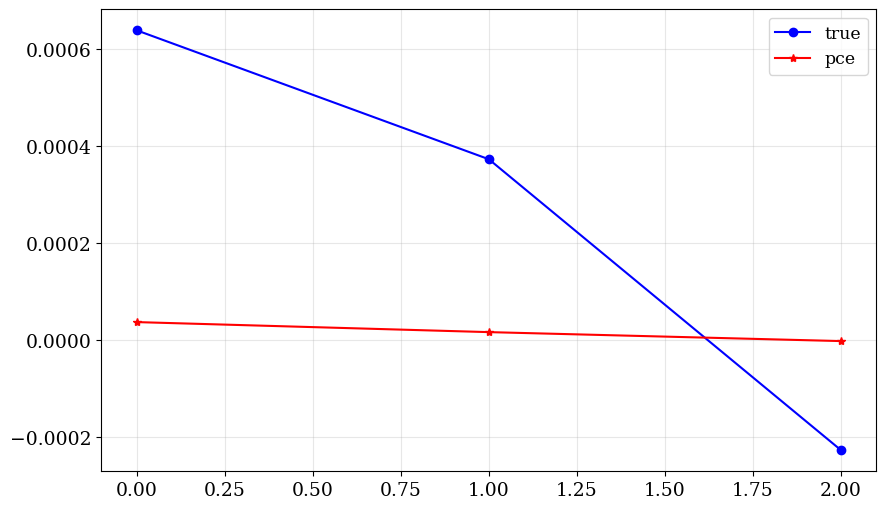

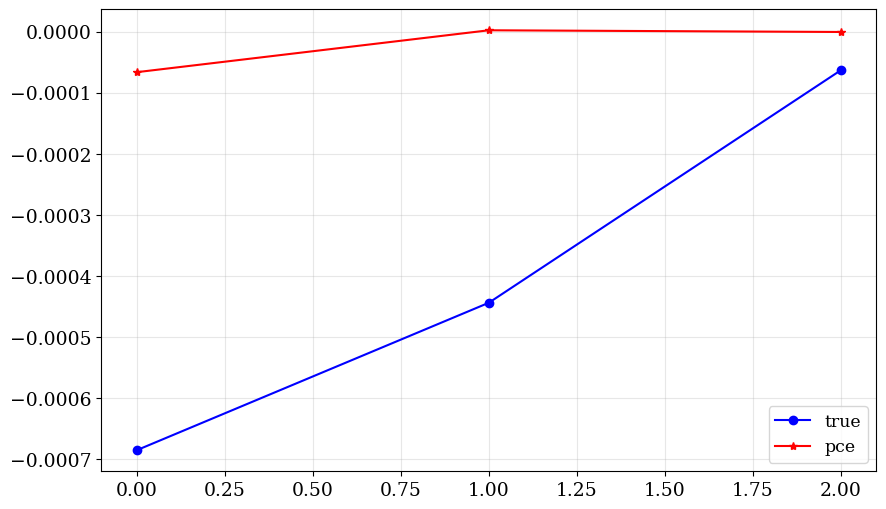

Error of PCE: [0.9994477 0.9993805 1.0040278]
--- Surrogate - 3.356570243835449 seconds ---


In [85]:
x = saltelli_1024

# Perform PCE on the manifold
start_time = time.time()

pce, error = PceModel(x=x, 
                      g=g, 
                      dist_obj=joint, 
                      max_degree=2, 
                      regression='Ridge',
                      verbose=True).get()

print('Error of PCE:', error)
print("--- Surrogate - %s seconds ---" % (time.time() - start_time))

In [86]:
pce.leaveoneout_error()

array([0.9980083, 1.004768 , 1.0046723])

# Charles: Combining both lambdas

In [7]:
with open('data/GLD/pop100_LMM.pickle', 'rb') as f:
    lambdas_LMM_result = pickle.load(f)

In [8]:
# We require a square matrix: 14x14=196 or 98+98 (remove two first tsteps from both lambdas tseries )
pop100_lambda34 = lambdas_LMM_result[:, :, 2:, 2:]


In [9]:
n_runs = 10
n_param_combos = 5120
n_responses = 2
n_steps = 98

pop100_lambda34_flat = np.zeros((n_runs, n_param_combos, n_responses*n_steps))

for run in range(n_runs):
    for param_id in range(n_param_combos):
        pop100_lambda34_flat[run, param_id, :] = pop100_lambda34[run][param_id].T.ravel()

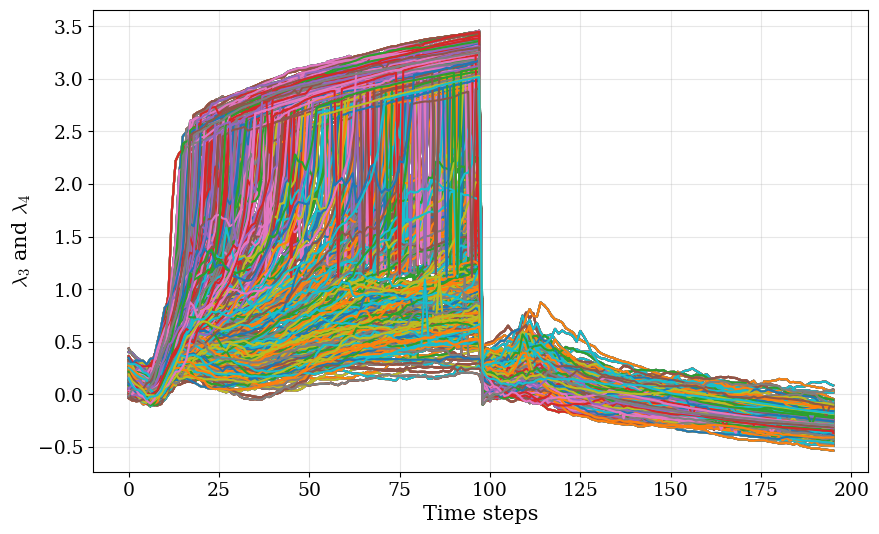

In [10]:
for i in range(5120):
    plt.plot(pop100_lambda34_flat[0, i])
plt.xlabel('Time steps')
plt.ylabel(r'$\lambda_3$ and $\lambda_4$')
plt.show()

In [16]:
n2 = n_responses*n_steps

pop100_lambda34_reshaped = pop100_lambda34_flat.reshape(10, 5120, int(np.sqrt(n2)), int(np.sqrt(n2)))

In [17]:
def run_GDMaps(p, 
               data, 
               num_runs=10, 
               n_keep=3, 
               parsim=True):
    
    evals_diff_runs  = []
    evecs_diff_runs  = []
    coord_diff_runs = []
    g_diff_runs = []
    residuals_diff_runs = []
    index_diff_runs = []
    
    for i in range(num_runs):
        print('Run: ', i)
        data_all = data[i]

        # Perform GDMAps
        start_time = time.time()
        
        if parsim:
            g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data_all, 
                                                                     n_evecs=20,
                                                                     n_keep=n_keep,
                                                                     parsim=parsim,
                                                                     p=p).get()
        
            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
            residuals_diff_runs.append(residuals)
            index_diff_runs.append(index)
            
        else:
            g, coord, Grass, evals, evecs = GDMaps(data=data_all, 
                                                   n_evecs=20,
                                                   n_keep=n_keep,
                                                   parsim=parsim,
                                                   p=p).get()
        
            evals_diff_runs.append(evals)
            evecs_diff_runs.append(evecs)
            coord_diff_runs.append(coord)
            g_diff_runs.append(g)
        
        print("--- GDMaps - %s seconds ---" % (time.time() - start_time))
    
    return (evals_diff_runs, evecs_diff_runs, coord_diff_runs, g_diff_runs,
            residuals_diff_runs, index_diff_runs)

In [18]:
if not os.path.exists('data/GSA_results/GLD'):
    os.makedirs('data/GSA_results/GLD')

In [19]:
if not os.path.exists(f'data/GSA_results/GLD/GLD_GDMaps_parsim_pop100_l34_runs_10_p_10.npz'):
    result = run_GDMaps(p=10, data=pop100_lambda34_reshaped)

    np.savez(f'data/GSA_results/GLD/GLD_GDMaps_parsim_pop100_l34_runs_10_p_10.npz', 
             x1 = result[0],  # evals_diff_runs
             x2 = result[1],  # evecs_diff_runs
             x3 = result[2],  # coord_diff_runs
             x4 = result[3],  # g_diff_runs
             x5 = result[4],  # residuals_diff_runs
             x6 = result[5],  # index_diff_runs
            )

Run:  0
Running with parsimonious representation
--- GDMaps - 681.7303318977356 seconds ---
Run:  1
Running with parsimonious representation
--- GDMaps - 669.7438127994537 seconds ---
Run:  2
Running with parsimonious representation
--- GDMaps - 690.3085010051727 seconds ---
Run:  3
Running with parsimonious representation
--- GDMaps - 669.6344749927521 seconds ---
Run:  4
Running with parsimonious representation
--- GDMaps - 685.0038521289825 seconds ---
Run:  5
Running with parsimonious representation
--- GDMaps - 658.4028458595276 seconds ---
Run:  6
Running with parsimonious representation
--- GDMaps - 633.9973118305206 seconds ---
Run:  7
Running with parsimonious representation
--- GDMaps - 656.2267718315125 seconds ---
Run:  8
Running with parsimonious representation
--- GDMaps - 848.7544710636139 seconds ---
Run:  9
Running with parsimonious representation
--- GDMaps - 753.8996469974518 seconds ---


In [20]:
GSA_results = np.load(f'data/GSA_results/GLD/GLD_GDMaps_parsim_pop100_l34_runs_10_p_10.npz', 
                      allow_pickle=True)

evals_diff_runs     = GSA_results['x1']
evecs_diff_runs     = GSA_results['x2']
coord_diff_runs     = GSA_results['x3']
g_diff_runs         = GSA_results['x4']
residuals_diff_runs = GSA_results['x5']
index_diff_runs     = GSA_results['x6']

In [23]:
def plot_evals_diff_runs(evals, n_runs):

    fig, axs = plt.subplots(figsize=(10, 5))

    for i in range(n_runs): 
        evals_ = evals[i]

        axs.plot(np.arange(1, len(evals_), 1), 
                 evals_[1:], 'd--', label=r'run=${}$'.format(i),
                 markeredgecolor='k', markeredgewidth=0.7,
                 markersize=7)
    axs.set_xlabel(r'Non-trivial eigenvalues $\lambda_i$ with $i > 0$')
    xticks = np.arange(1, len(evals_), 1)
    axs.set_xticks(xticks,
                  ['{}'.format(num) for num in xticks], 
                  rotation=90)
    axs.legend()
    plt.show()
    
    
def plot_dm_parsim_coord(coord, g):
    
    comb1 = list(it.combinations(list(coord), 2))
    comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))
    
#     print(f'comb1: {comb1}')
#     print(f'comb2: {comb2}')

    # Plot first three plots
    if coord.shape[0] > 2:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
        
        for i in range(len(comb1)):
            ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            ax[i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            ax[i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            ax[i].grid('True')
            ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        plt.show()

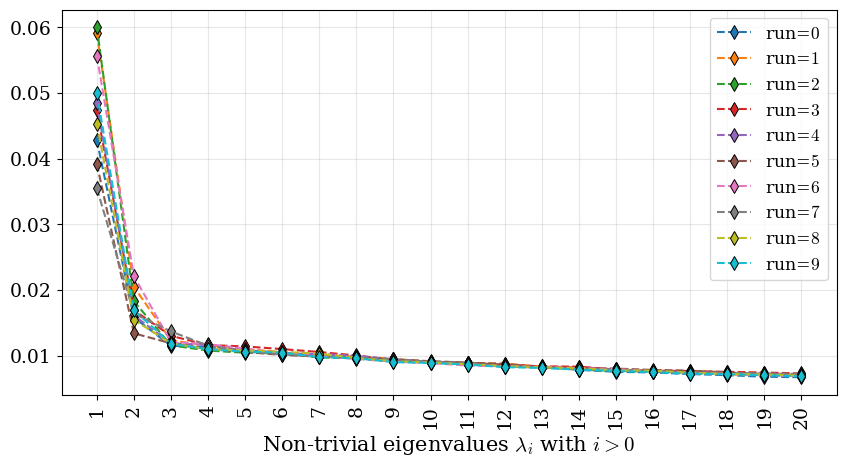

In [24]:
plot_evals_diff_runs(evals_diff_runs, 10)

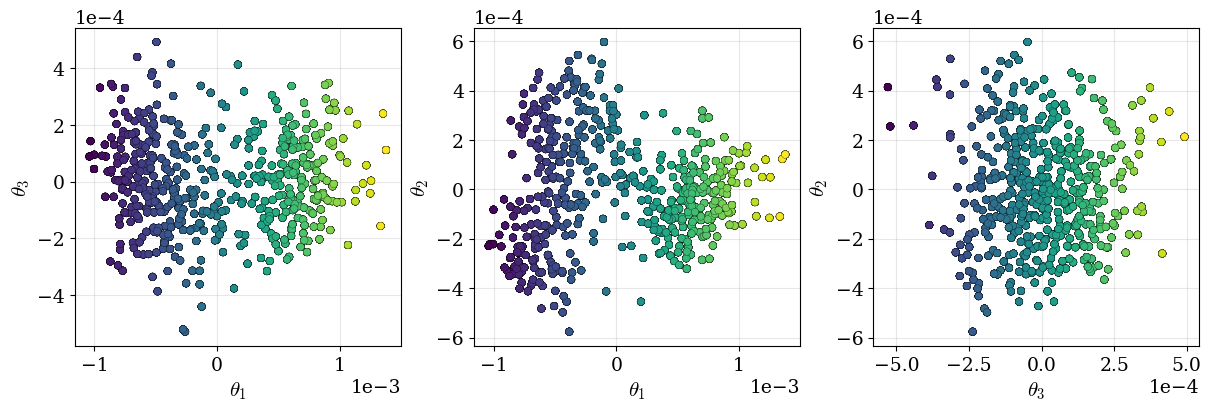

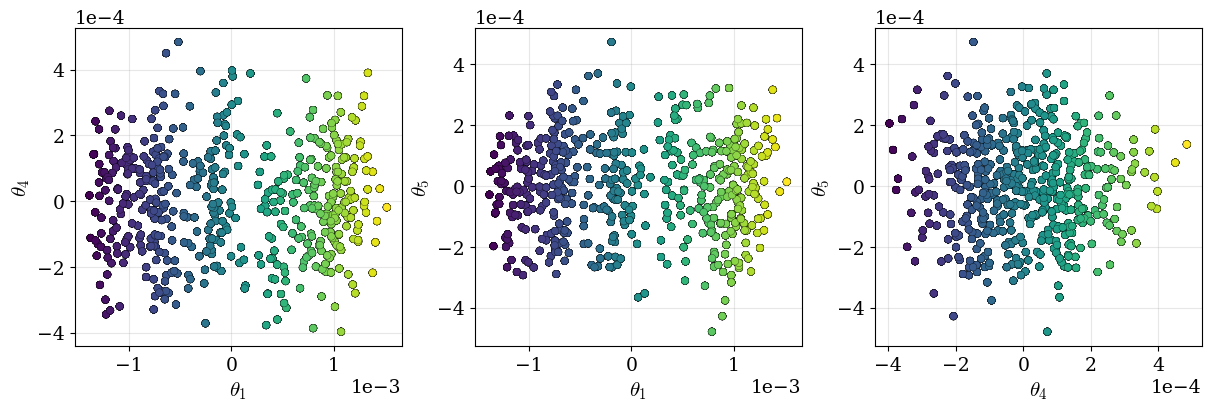

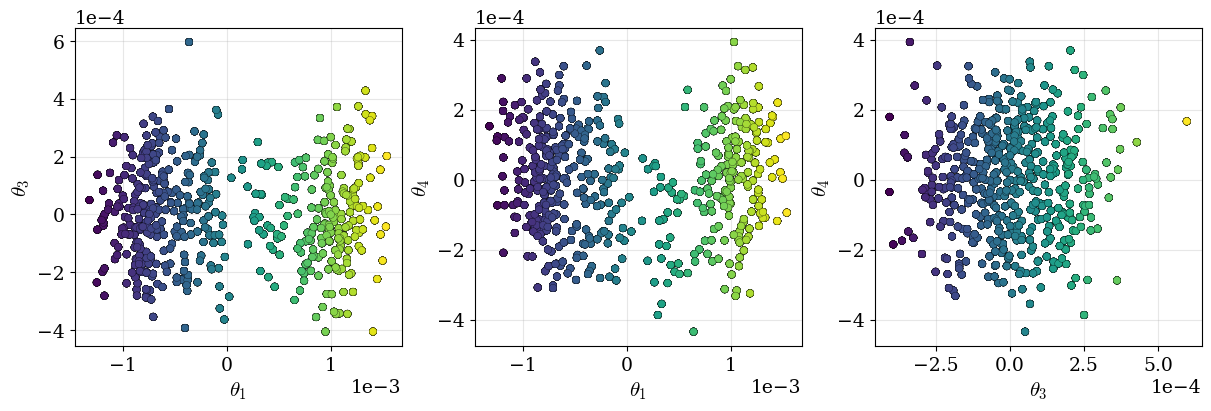

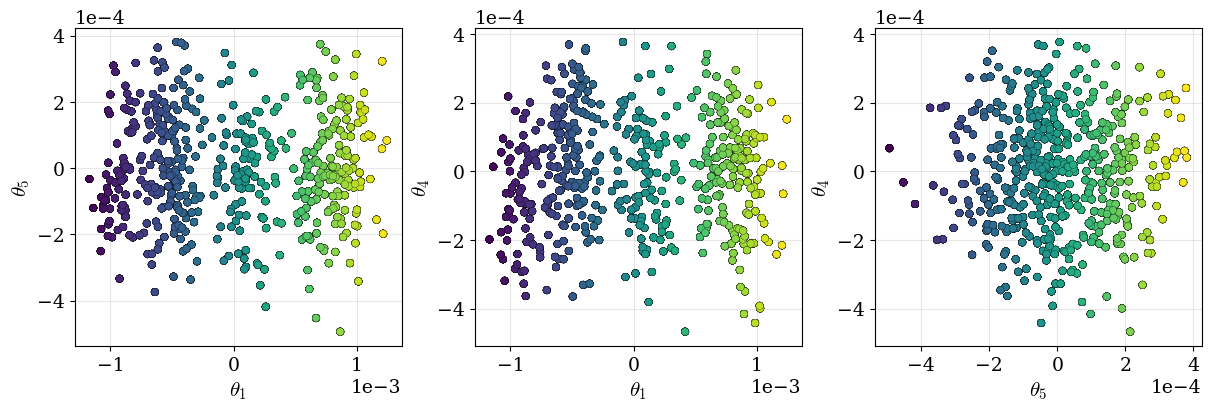

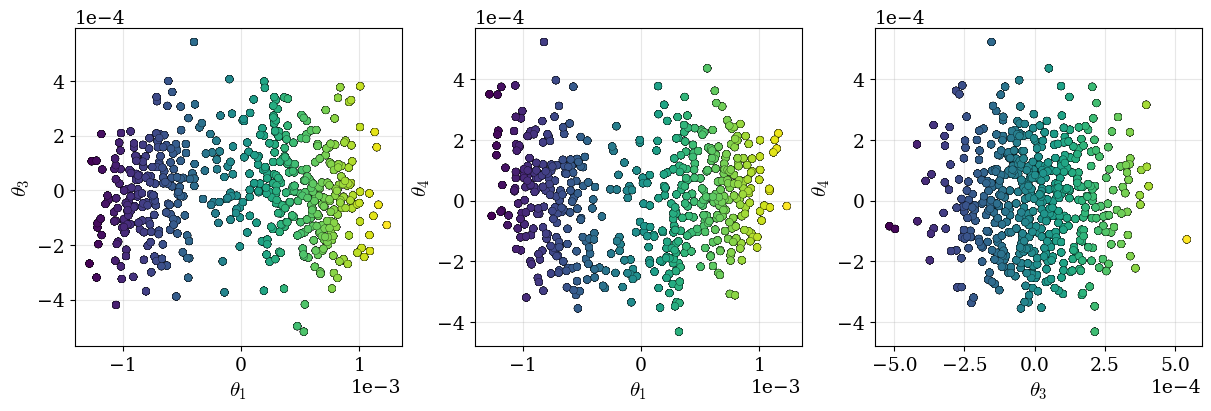

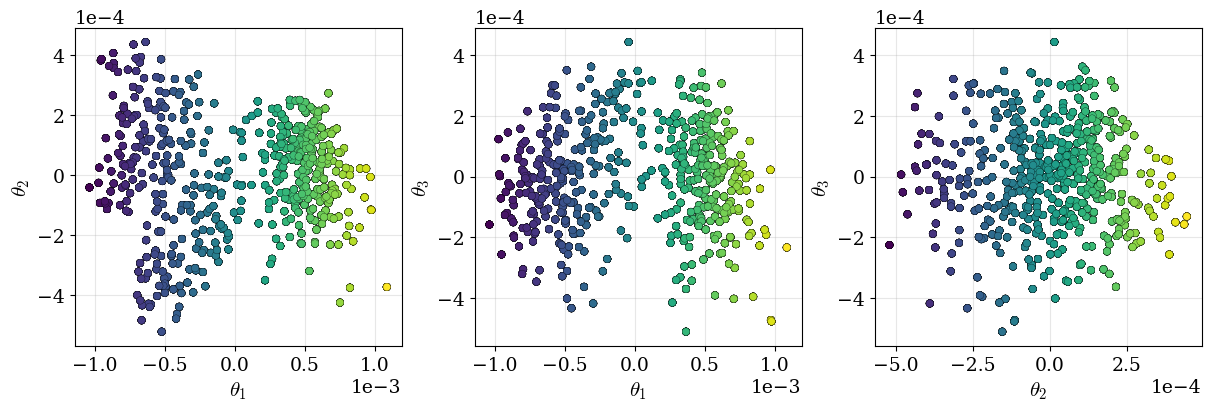

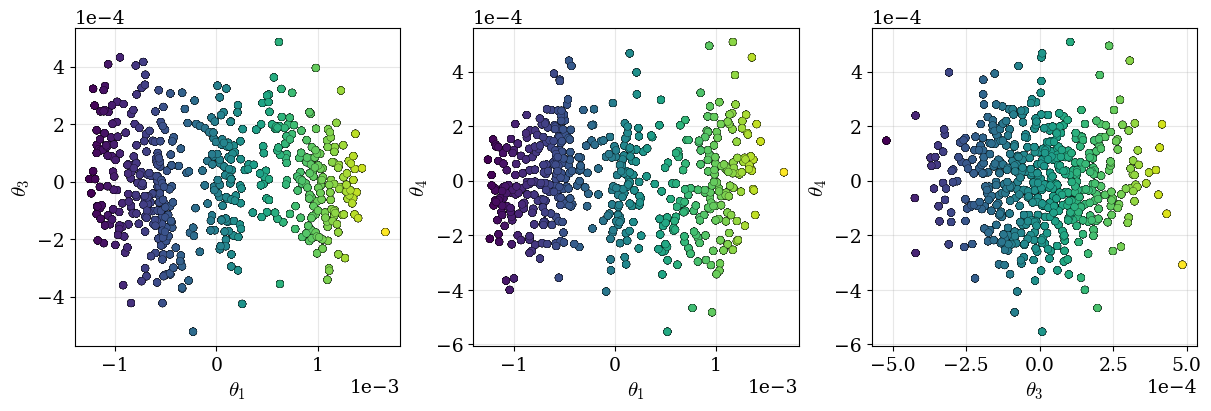

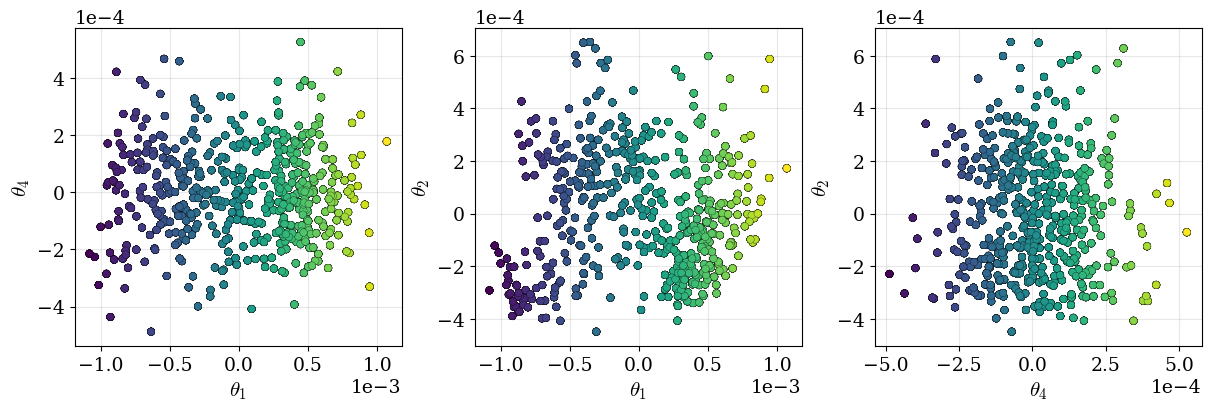

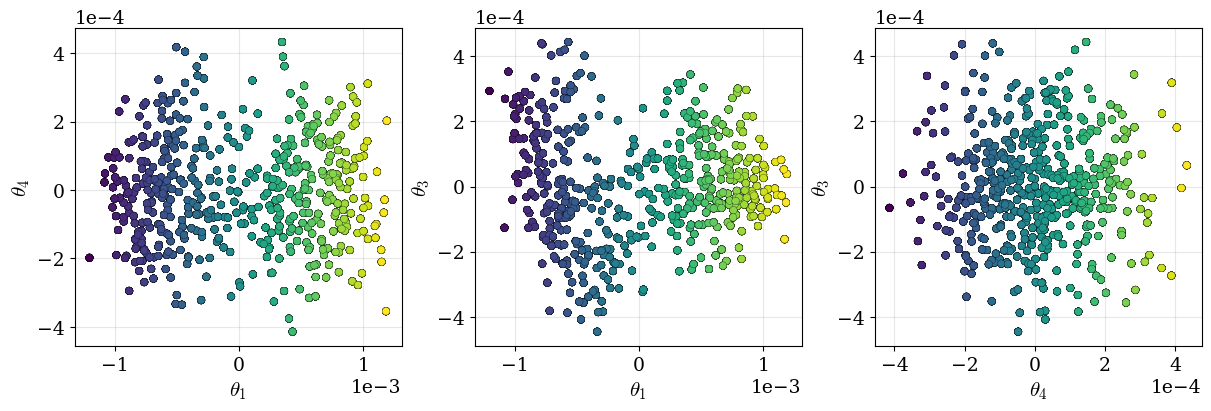

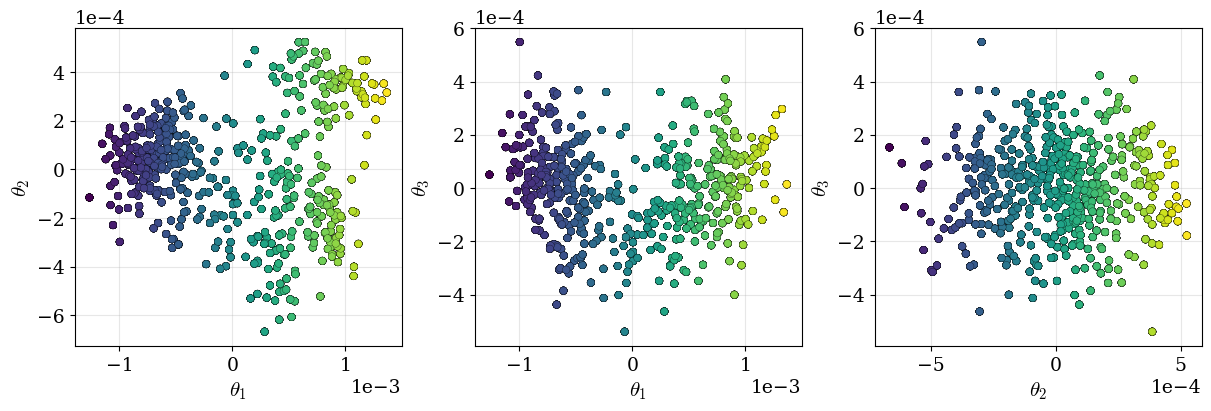

In [25]:
for i in range(10):
    g = g_diff_runs[i]
    coord = coord_diff_runs[i]
    plot_dm_parsim_coord(coord, g)

In [26]:
def PCE_LAR_model_selection(x, g, n_params, dist_obj, max_degree):
  
    n_dcoords = g.shape[1]
    
    # construct total-degree polynomial basis
    polynomial_basis = TotalDegreeBasis(joint, max_degree)

    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    xx_train, xx_test, \
        gg_train, gg_test = train_test_split(x, g, train_size=2 / 3, random_state=1)

    error_pce = np.zeros((n_dcoords))
    LOO_pce   = np.zeros((n_dcoords))
    pce_fo_si = np.zeros((n_params, n_dcoords))
    pce_to_si = np.zeros((n_params, n_dcoords))

    error_pceLAR = np.zeros((n_dcoords))
    MAE_pceLAR   = np.zeros((n_dcoords))
    LOO_pceLAR   = np.zeros((n_dcoords))
    pceLAR_fo_si = np.zeros((n_params, n_dcoords))
    pceLAR_to_si = np.zeros((n_params, n_dcoords))

    for i in range(3):
#         print('Theta',i)
        
        pce.fit(xx_train, gg_train[:, i])

        error_pce[i] = ErrorEstimation(surr_object=pce).validation(xx_test, gg_test[:, i])
        LOO_pce[i] = pce.leaveoneout_error()

        # sensitivity from PCE
        pce_sensitivity = PceSensitivity(pce)
        pce_sensitivity.run()

        sobol_first = pce_sensitivity.first_order_indices
        sobol_total = pce_sensitivity.total_order_indices

        pce_fo_si[:, i] = sobol_first.T
        pce_to_si[:, i] = sobol_total.T

        # Lars model selection
        print('Size of the full set of PCE basis:', polynomial_basis.polynomials_number)

        target_error = 1
        CheckOverfitting = True
        pceLAR = polynomial_chaos.regressions.LeastAngleRegression.model_selection(pce, 
                                                                                   target_error, 
                                                                                   CheckOverfitting)

        print('Size of the LAR PCE basis:', pceLAR.polynomial_basis.polynomials_number)

        n_samples_val = len(xx_test)
        gg_test_pce = pceLAR.predict(xx_test).flatten()
        errors = np.abs(gg_test[:, i].flatten() - gg_test_pce)
        MAE = (np.linalg.norm(errors, 1) / n_samples_val)

        error_pceLAR[i] = ErrorEstimation(surr_object=pceLAR).validation(xx_test, gg_test[:, i])
        MAE_pceLAR[i]   = MAE               
        LOO_pceLAR[i]   = pceLAR.leaveoneout_error()

        print('Mean absolute error:', MAE)
        print('Leave-one-out cross validation on ED:', pceLAR.leaveoneout_error())

        pceLAR_sensitivity = PceSensitivity(pceLAR)
        pceLAR_sensitivity.run()

        LAR_sobol_first = pceLAR_sensitivity.first_order_indices
        LAR_sobol_total = pceLAR_sensitivity.total_order_indices

        pceLAR_fo_si[:, i] = LAR_sobol_first.T
        pceLAR_to_si[:, i] = LAR_sobol_total.T
        
    return (error_pce, LOO_pce, pce_fo_si, pce_to_si,
            error_pceLAR, LOO_pceLAR, MAE_pceLAR, pceLAR_fo_si, pceLAR_to_si)

In [28]:
param_names = {
    'Heterogeneity_endowment': r'$H_e$',
    'Heterogeneity_metabolism': r'$H_m$', 
    'Heterogeneity_vision': r'$H_v$'
}

problem = {
    'h_e': [float, [0.01, 1]],
    'h_m': [float, [0.01, 1]],
    'h_v': [float, [0.01, 1]],
}

problem_sampler = {
    'num_vars': len(problem),
    'names': [key for key in sorted(problem.keys())],
    'bounds': [problem[key][1] for key in sorted(problem.keys())]
}

saltelli_1024 = np.loadtxt('data/Sobol/saltellisample_1024')

x = saltelli_1024

print(f'Problem bounds: {problem_sampler["bounds"]}')

pdf1 = Uniform(loc=0.01, scale=0.99)  
pdf2 = Uniform(loc=0.01, scale=0.99)  
pdf3 = Uniform(loc=0.01, scale=0.99)  

margs = [pdf1, pdf2, pdf3]
joint = JointIndependent(marginals=margs)

Problem bounds: [[0.01, 1], [0.01, 1], [0.01, 1]]


In [29]:
s_max = np.linspace(2, 20, 19, dtype='int')
n_runs = 10
n_dcoords = 3
n_params = 3

ols_fo_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
ols_to_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
ols_error = np.zeros((n_runs, len(s_max), n_dcoords))
ols_LOO   = np.zeros((n_runs, len(s_max), n_dcoords))

ridge_fo_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
ridge_to_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
ridge_error = np.zeros((n_runs, len(s_max), n_dcoords))
ridge_LOO   = np.zeros((n_runs, len(s_max), n_dcoords))

LAR_fo_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_to_si = np.zeros((n_runs, len(s_max), n_params, n_dcoords))
LAR_error = np.zeros((n_runs, len(s_max), n_dcoords))
LAR_LOO   = np.zeros((n_runs, len(s_max), n_dcoords))

for run in range(10):
    print("Run:", run)
    g = g_diff_runs[run]
    
    for i, s in enumerate(s_max):
        print("Max polynomial degree:", s)
        
        start_time = time.time()
        LAR_result = PCE_LAR_model_selection(x=x, 
                                             g=g, 
                                             n_params=3, 
                                             dist_obj=joint, 
                                             max_degree=s)

        ols_fo_si[run, i] = LAR_result[2]
        ols_to_si[run, i] = LAR_result[3]
        ols_error[run, i] = LAR_result[0]
        ols_LOO[run, i]   = LAR_result[1]
        
        LAR_fo_si[run, i] = LAR_result[7]
        LAR_to_si[run, i] = LAR_result[8]
        LAR_error[run, i] = LAR_result[4]
        LAR_LOO[run, i]   = LAR_result[5]
        
        print("--- PCE-OLD and PCE-LAR - %s seconds ---" % (time.time() - start_time))
        
        start_time = time.time()
        Ridge_pce, Ridge_error = PceModel(x=x, 
                                        g=g, 
                                        dist_obj=joint, 
                                        max_degree=s, 
                                        regression='Ridge',
                                        verbose=False).get()
        
        ridge_fo_si[run, i] = PceSensitivity(Ridge_pce).calculate_first_order_indices()
        ridge_to_si[run, i] = PceSensitivity(Ridge_pce).calculate_total_order_indices()
        ridge_error[run, i] = Ridge_error
        ridge_LOO[run, i]   = Ridge_pce.leaveoneout_error()
        print("--- PCE-Ridge - %s seconds ---" % (time.time() - start_time))       
        

Run: 0
Max polynomial degree: 2
Size of the full set of PCE basis: 10
Size of the LAR PCE basis: 4
Mean absolute error: 0.0005363568703667006
Leave-one-out cross validation on ED: 0.9923443
Size of the full set of PCE basis: 10
Size of the LAR PCE basis: 5
Mean absolute error: 0.00012380813584119595
Leave-one-out cross validation on ED: 0.9991805
Size of the full set of PCE basis: 10
Size of the LAR PCE basis: 3
Mean absolute error: 0.00017697317295305325
Leave-one-out cross validation on ED: 1.000135
--- PCE-OLD and PCE-LAR - 0.2523958683013916 seconds ---
Size of the full set of PCE basis: 10
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 1.9108901023864746 seconds ---
Max polynomial degree: 3
Size of the full set of PCE basis: 20
Size of the LAR PCE basis: 4
Mean absolute error: 0.0005363568703667006
Leave-one-out cross validation on ED: 0.9923443
Size of the full set of PCE basis: 20
Size of the LAR PCE basis: 5
Mean absolute err

Size of the full set of PCE basis: 560
Size of the LAR PCE basis: 103
Mean absolute error: 0.000132542210860725
Leave-one-out cross validation on ED: 0.9574635
Size of the full set of PCE basis: 560
Size of the LAR PCE basis: 121
Mean absolute error: 0.000184576625362411
Leave-one-out cross validation on ED: 0.9619043
--- PCE-OLD and PCE-LAR - 794.9379699230194 seconds ---
Size of the full set of PCE basis: 560
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 24.133920192718506 seconds ---
Max polynomial degree: 14
Size of the full set of PCE basis: 680
Size of the LAR PCE basis: 113
Mean absolute error: 0.0005506128163454448
Leave-one-out cross validation on ED: 0.9445189
Size of the full set of PCE basis: 680
Size of the LAR PCE basis: 97
Mean absolute error: 0.0001319671457314402
Leave-one-out cross validation on ED: 0.9496686
Size of the full set of PCE basis: 680
Size of the LAR PCE basis: 127
Mean absolute error: 0.00018588429212

Size of the LAR PCE basis: 5
Mean absolute error: 0.00012242359591761102
Leave-one-out cross validation on ED: 0.9973223
--- PCE-OLD and PCE-LAR - 2.610193967819214 seconds ---
Size of the full set of PCE basis: 56
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 2.4241509437561035 seconds ---
Max polynomial degree: 6
Size of the full set of PCE basis: 84
Size of the LAR PCE basis: 13
Mean absolute error: 0.0007271264896666494
Leave-one-out cross validation on ED: 0.9877458
Size of the full set of PCE basis: 84
Size of the LAR PCE basis: 15
Mean absolute error: 0.00013371126149991412
Leave-one-out cross validation on ED: 0.9949341
Size of the full set of PCE basis: 84
Size of the LAR PCE basis: 7
Mean absolute error: 0.0001222908588867519
Leave-one-out cross validation on ED: 0.9963011
--- PCE-OLD and PCE-LAR - 6.167963981628418 seconds ---
Size of the full set of PCE basis: 84
Shape of the training set (x)): (3413, 3)
Shape of the tra

Size of the full set of PCE basis: 969
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 43.695064067840576 seconds ---
Max polynomial degree: 17
Size of the full set of PCE basis: 1140
Size of the LAR PCE basis: 229
Mean absolute error: 0.0007686738220589764
Leave-one-out cross validation on ED: 0.9185948
Size of the full set of PCE basis: 1140
Size of the LAR PCE basis: 226
Mean absolute error: 0.0001441338993516977
Leave-one-out cross validation on ED: 0.9162442
Size of the full set of PCE basis: 1140
Size of the LAR PCE basis: 179
Mean absolute error: 0.0001303961868245284
Leave-one-out cross validation on ED: 0.9153711
--- PCE-OLD and PCE-LAR - 1501.219830751419 seconds ---
Size of the full set of PCE basis: 1140
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 50.3244411945343 seconds ---
Max polynomial degree: 18
Size of the full set of PCE basis: 1330
Size of the LAR PCE basis: 

Size of the full set of PCE basis: 220
Size of the LAR PCE basis: 25
Mean absolute error: 0.0007666161110170283
Leave-one-out cross validation on ED: 0.9805
Size of the full set of PCE basis: 220
Size of the LAR PCE basis: 34
Mean absolute error: 0.00013006597833493442
Leave-one-out cross validation on ED: 0.9847033
Size of the full set of PCE basis: 220
Size of the LAR PCE basis: 37
Mean absolute error: 0.00012458490966507993
Leave-one-out cross validation on ED: 0.9782857
--- PCE-OLD and PCE-LAR - 48.37101411819458 seconds ---
Size of the full set of PCE basis: 220
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 7.865725040435791 seconds ---
Max polynomial degree: 10
Size of the full set of PCE basis: 286
Size of the LAR PCE basis: 27
Mean absolute error: 0.0007649938923044095
Leave-one-out cross validation on ED: 0.9772142
Size of the full set of PCE basis: 286
Size of the LAR PCE basis: 52
Mean absolute error: 0.000129826160903762

Size of the full set of PCE basis: 1771
Size of the LAR PCE basis: 320
Mean absolute error: 0.0001418632858917574
Leave-one-out cross validation on ED: 0.8873065
Size of the full set of PCE basis: 1771
Size of the LAR PCE basis: 315
Mean absolute error: 0.0001346780377865108
Leave-one-out cross validation on ED: 0.8803814
--- PCE-OLD and PCE-LAR - 1664.7301120758057 seconds ---
Size of the full set of PCE basis: 1771
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 85.72704696655273 seconds ---
Run: 3
Max polynomial degree: 2
Size of the full set of PCE basis: 10
Size of the LAR PCE basis: 3
Mean absolute error: 0.0005823514263156737
Leave-one-out cross validation on ED: 0.9954053
Size of the full set of PCE basis: 10
Size of the LAR PCE basis: 3
Mean absolute error: 0.00012917235836781146
Leave-one-out cross validation on ED: 1.0010072
Size of the full set of PCE basis: 10
Size of the LAR PCE basis: 3
Mean absolute error: 0.0001326265

Size of the full set of PCE basis: 455
Size of the LAR PCE basis: 65
Mean absolute error: 0.00013718824028425907
Leave-one-out cross validation on ED: 0.9644721
--- PCE-OLD and PCE-LAR - 393.3105890750885 seconds ---
Size of the full set of PCE basis: 455
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 19.984232187271118 seconds ---
Max polynomial degree: 13
Size of the full set of PCE basis: 560
Size of the LAR PCE basis: 81
Mean absolute error: 0.0005981887791704767
Leave-one-out cross validation on ED: 0.9582744
Size of the full set of PCE basis: 560
Size of the LAR PCE basis: 73
Mean absolute error: 0.00013276318016664055
Leave-one-out cross validation on ED: 0.9641089
Size of the full set of PCE basis: 560
Size of the LAR PCE basis: 81
Mean absolute error: 0.00013809744482133572
Leave-one-out cross validation on ED: 0.9578976
--- PCE-OLD and PCE-LAR - 624.3307991027832 seconds ---
Size of the full set of PCE basis: 560
Shape of t

Size of the full set of PCE basis: 35
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 2.1304728984832764 seconds ---
Max polynomial degree: 5
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 11
Mean absolute error: 0.0006045724147897936
Leave-one-out cross validation on ED: 0.9894468
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 8
Mean absolute error: 0.00013328605379232762
Leave-one-out cross validation on ED: 0.9958989
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 8
Mean absolute error: 0.0001315368070690691
Leave-one-out cross validation on ED: 0.9990055
--- PCE-OLD and PCE-LAR - 2.6219518184661865 seconds ---
Size of the full set of PCE basis: 56
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 2.3966877460479736 seconds ---
Max polynomial degree: 6
Size of the full set of PCE basis: 84
Size of the LAR PCE basis: 16
Mean absolu

Size of the full set of PCE basis: 969
Size of the LAR PCE basis: 169
Mean absolute error: 0.0006244402156528679
Leave-one-out cross validation on ED: 0.9262423
Size of the full set of PCE basis: 969
Size of the LAR PCE basis: 179
Mean absolute error: 0.0001434243107450857
Leave-one-out cross validation on ED: 0.9261354
Size of the full set of PCE basis: 969
Size of the LAR PCE basis: 164
Mean absolute error: 0.0001392803633869248
Leave-one-out cross validation on ED: 0.9438609
--- PCE-OLD and PCE-LAR - 1429.4202511310577 seconds ---
Size of the full set of PCE basis: 969
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 44.082191944122314 seconds ---
Max polynomial degree: 17
Size of the full set of PCE basis: 1140
Size of the LAR PCE basis: 210
Mean absolute error: 0.0006296246620236586
Leave-one-out cross validation on ED: 0.9092137
Size of the full set of PCE basis: 1140
Size of the LAR PCE basis: 160
Mean absolute error: 0.00014209

Size of the LAR PCE basis: 26
Mean absolute error: 0.00015341365734567196
Leave-one-out cross validation on ED: 0.9875694
Size of the full set of PCE basis: 165
Size of the LAR PCE basis: 33
Mean absolute error: 0.00013679642381784034
Leave-one-out cross validation on ED: 0.9832829
--- PCE-OLD and PCE-LAR - 27.088743925094604 seconds ---
Size of the full set of PCE basis: 165
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 5.541325092315674 seconds ---
Max polynomial degree: 9
Size of the full set of PCE basis: 220
Size of the LAR PCE basis: 28
Mean absolute error: 0.0004917982108770587
Leave-one-out cross validation on ED: 0.9786788
Size of the full set of PCE basis: 220
Size of the LAR PCE basis: 30
Mean absolute error: 0.00015437092100642876
Leave-one-out cross validation on ED: 0.9831778
Size of the full set of PCE basis: 220
Size of the LAR PCE basis: 47
Mean absolute error: 0.00013711476026296592
Leave-one-out cross validation o

Size of the full set of PCE basis: 1540
Size of the LAR PCE basis: 249
Mean absolute error: 0.0001465790899476947
Leave-one-out cross validation on ED: 0.8940467
--- PCE-OLD and PCE-LAR - 1694.4039750099182 seconds ---
Size of the full set of PCE basis: 1540
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 69.88638687133789 seconds ---
Max polynomial degree: 20
Size of the full set of PCE basis: 1771
Size of the LAR PCE basis: 317
Mean absolute error: 0.0005165063475459757
Leave-one-out cross validation on ED: 0.8860207
Size of the full set of PCE basis: 1771
Size of the LAR PCE basis: 280
Mean absolute error: 0.00016853425009833714
Leave-one-out cross validation on ED: 0.8892535
Size of the full set of PCE basis: 1771
Size of the LAR PCE basis: 343
Mean absolute error: 0.0001515342958728974
Leave-one-out cross validation on ED: 0.8850554
--- PCE-OLD and PCE-LAR - 1787.838594198227 seconds ---
Size of the full set of PCE basis: 1771
Sh

Size of the full set of PCE basis: 364
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 20.51996111869812 seconds ---
Max polynomial degree: 12
Size of the full set of PCE basis: 455
Size of the LAR PCE basis: 73
Mean absolute error: 0.0007044408231518812
Leave-one-out cross validation on ED: 0.957285
Size of the full set of PCE basis: 455
Size of the LAR PCE basis: 67
Mean absolute error: 0.00014057882506879473
Leave-one-out cross validation on ED: 0.9690007
Size of the full set of PCE basis: 455
Size of the LAR PCE basis: 61
Mean absolute error: 0.0001362118263579333
Leave-one-out cross validation on ED: 0.9685058
--- PCE-OLD and PCE-LAR - 389.1576898097992 seconds ---
Size of the full set of PCE basis: 455
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 19.82526922225952 seconds ---
Max polynomial degree: 13
Size of the full set of PCE basis: 560
Size of the LAR PCE basis: 80
Mean 

Size of the LAR PCE basis: 3
Mean absolute error: 0.00042345900783396633
Leave-one-out cross validation on ED: 0.9942385
Size of the full set of PCE basis: 35
Size of the LAR PCE basis: 3
Mean absolute error: 0.0001270098167801821
Leave-one-out cross validation on ED: 0.9998895
Size of the full set of PCE basis: 35
Size of the LAR PCE basis: 6
Mean absolute error: 0.00019054573829425036
Leave-one-out cross validation on ED: 0.9968982
--- PCE-OLD and PCE-LAR - 0.9970500469207764 seconds ---
Size of the full set of PCE basis: 35
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 2.164364814758301 seconds ---
Max polynomial degree: 5
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 7
Mean absolute error: 0.0004227017934819896
Leave-one-out cross validation on ED: 0.9917693
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 5
Mean absolute error: 0.00012714002377093252
Leave-one-out cross validation on ED: 0.998

Size of the LAR PCE basis: 140
Mean absolute error: 0.00013598627335982595
Leave-one-out cross validation on ED: 0.9443511
Size of the full set of PCE basis: 816
Size of the LAR PCE basis: 189
Mean absolute error: 0.00019798819300020776
Leave-one-out cross validation on ED: 0.9392717
--- PCE-OLD and PCE-LAR - 1371.2460811138153 seconds ---
Size of the full set of PCE basis: 816
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 35.04757499694824 seconds ---
Max polynomial degree: 16
Size of the full set of PCE basis: 969
Size of the LAR PCE basis: 167
Mean absolute error: 0.00044705686423397094
Leave-one-out cross validation on ED: 0.9318634
Size of the full set of PCE basis: 969
Size of the LAR PCE basis: 161
Mean absolute error: 0.00013492819512083876
Leave-one-out cross validation on ED: 0.9276527
Size of the full set of PCE basis: 969
Size of the LAR PCE basis: 165
Mean absolute error: 0.0001974846494759298
Leave-one-out cross valida

Size of the LAR PCE basis: 25
Mean absolute error: 0.00013163833933609078
Leave-one-out cross validation on ED: 0.9871818
--- PCE-OLD and PCE-LAR - 13.725226879119873 seconds ---
Size of the full set of PCE basis: 120
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 3.9424939155578613 seconds ---
Max polynomial degree: 8
Size of the full set of PCE basis: 165
Size of the LAR PCE basis: 21
Mean absolute error: 0.000575084693288067
Leave-one-out cross validation on ED: 0.9803176
Size of the full set of PCE basis: 165
Size of the LAR PCE basis: 25
Mean absolute error: 0.00012628628205658976
Leave-one-out cross validation on ED: 0.9843214
Size of the full set of PCE basis: 165
Size of the LAR PCE basis: 30
Mean absolute error: 0.00013213472534656458
Leave-one-out cross validation on ED: 0.9837958
--- PCE-OLD and PCE-LAR - 26.73695206642151 seconds ---
Size of the full set of PCE basis: 165
Shape of the training set (x)): (3413, 3)
Shape of

Size of the full set of PCE basis: 1330
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 58.834503173828125 seconds ---
Max polynomial degree: 19
Size of the full set of PCE basis: 1540
Size of the LAR PCE basis: 169
Mean absolute error: 0.0005872117882201592
Leave-one-out cross validation on ED: 0.9108877
Size of the full set of PCE basis: 1540
Size of the LAR PCE basis: 212
Mean absolute error: 0.00013397790788637276
Leave-one-out cross validation on ED: 0.8961497
Size of the full set of PCE basis: 1540
Size of the LAR PCE basis: 247
Mean absolute error: 0.0001407309446791122
Leave-one-out cross validation on ED: 0.8862808
--- PCE-OLD and PCE-LAR - 1646.075449705124 seconds ---
Size of the full set of PCE basis: 1540
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 69.90705895423889 seconds ---
Max polynomial degree: 20
Size of the full set of PCE basis: 1771
Size of the LAR PCE basi

Size of the full set of PCE basis: 364
Size of the LAR PCE basis: 50
Mean absolute error: 0.0006349517158305994
Leave-one-out cross validation on ED: 0.9664751
Size of the full set of PCE basis: 364
Size of the LAR PCE basis: 57
Mean absolute error: 0.00019996517743189318
Leave-one-out cross validation on ED: 0.9816584
Size of the full set of PCE basis: 364
Size of the LAR PCE basis: 56
Mean absolute error: 0.00013189541726695735
Leave-one-out cross validation on ED: 0.9812097
--- PCE-OLD and PCE-LAR - 180.90884971618652 seconds ---
Size of the full set of PCE basis: 364
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
--- PCE-Ridge - 14.634528875350952 seconds ---
Max polynomial degree: 12
Size of the full set of PCE basis: 455
Size of the LAR PCE basis: 74
Mean absolute error: 0.000629247338146702
Leave-one-out cross validation on ED: 0.9595027
Size of the full set of PCE basis: 455
Size of the LAR PCE basis: 66
Mean absolute error: 0.00020043991766

In [30]:
if not os.path.exists('data/GSA_GDMaps_PCE/GLD'):
    os.makedirs('data/GSA_GDMaps_PCE/GLD')

In [31]:
if not os.path.exists(f'data/GSA_GDMaps_PCE/GLD/smax_2_20_GLD_pop100_l34_runs_10_p_10.npz'):    
    np.savez(f'data/GSA_GDMaps_PCE/GLD/smax_2_20_GLD_pop100_l34_runs_10_p_10.npz', 
             x1 = ols_fo_si, 
             x2 = ols_to_si,
             x3 = ols_error,
             x4 = ols_LOO,
             x5 = ridge_fo_si,
             x6 = ridge_to_si,
             x7 = ridge_error,
             x8 = ridge_LOO,
             x9  = LAR_fo_si,
             x10 = LAR_to_si,
             x11 = LAR_error,
             x12 = LAR_LOO
            )

In [32]:
diff_smax_l34_p10 = np.load('data/GSA_GDMaps_PCE/GLD/smax_2_20_GLD_pop100_l34_runs_10_p_10.npz', 
                            allow_pickle=True)

r_ols_fo_si     = diff_smax_l34_p10['x1']
r_ols_to_si     = diff_smax_l34_p10['x2']
r_ols_error     = diff_smax_l34_p10['x3']
r_ols_LOO       = diff_smax_l34_p10['x4']
r_ridge_fo_si   = diff_smax_l34_p10['x5']
r_ridge_to_si   = diff_smax_l34_p10['x6']
r_ridge_error   = diff_smax_l34_p10['x7']
r_ridge_LOO     = diff_smax_l34_p10['x8']
r_LAR_fo_si     = diff_smax_l34_p10['x9']
r_LAR_to_si     = diff_smax_l34_p10['x10']
r_LAR_error     = diff_smax_l34_p10['x11']
r_LAR_LOO       = diff_smax_l34_p10['x12']

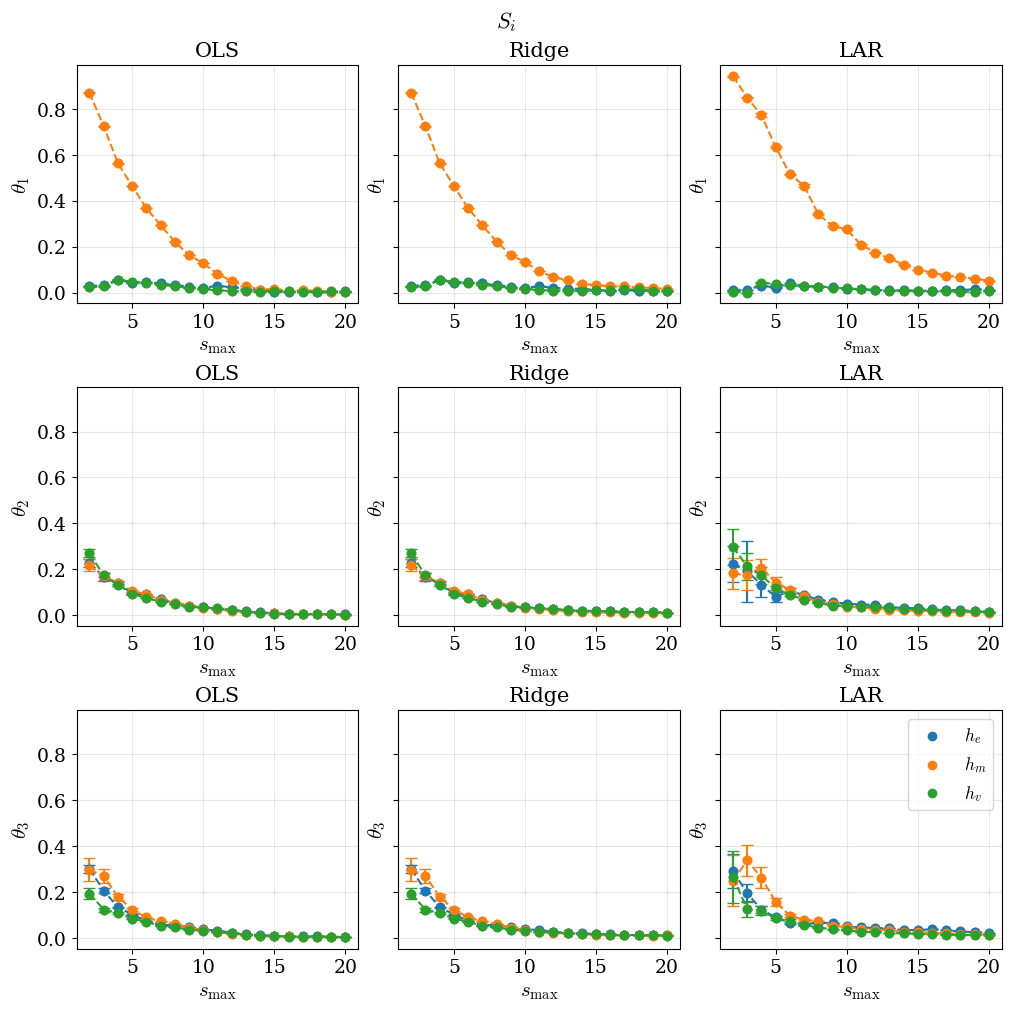

In [33]:
param_names = [r"$h_e$", r"$h_m$", r"$h_v$"]
    
n_d_coord = 3

fig, axs = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True, sharey=True)

for d in range(n_d_coord):
    for i, param in enumerate(param_names):
        axs[d,0].scatter(s_max, r_ols_fo_si.mean(axis=0)[:, i, d], label=param)
        axs[d,0].errorbar(s_max, r_ols_fo_si.mean(axis=0)[:, i, d],
                          r_ols_fo_si.var(axis=0, ddof=1)[:, i, d],
                          linestyle='--', marker='o', capsize=4)
        axs[d,0].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,0].set(title=r"OLS")
        
        axs[d,1].scatter(s_max, r_ridge_fo_si.mean(axis=0)[:, i, d], label=param)
        axs[d,1].errorbar(s_max, r_ridge_fo_si.mean(axis=0)[:, i, d],
                          r_ridge_fo_si.var(axis=0, ddof=1)[:, i, d],
                          linestyle='--', marker='o', capsize=4)
        axs[d,1].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,1].set(title=r"Ridge")
        
        axs[d,2].scatter(s_max, r_LAR_fo_si.mean(axis=0)[:, i, d], label=param)
        axs[d,2].errorbar(s_max, r_LAR_fo_si.mean(axis=0)[:, i, d],
                          r_LAR_fo_si.var(axis=0, ddof=1)[:, i, d],
                          linestyle='--', marker='o', capsize=4)
        axs[d,2].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,2].set(title=r"LAR")
        
plt.legend() 
plt.suptitle(r"$S_{i}$")
        
plt.show()

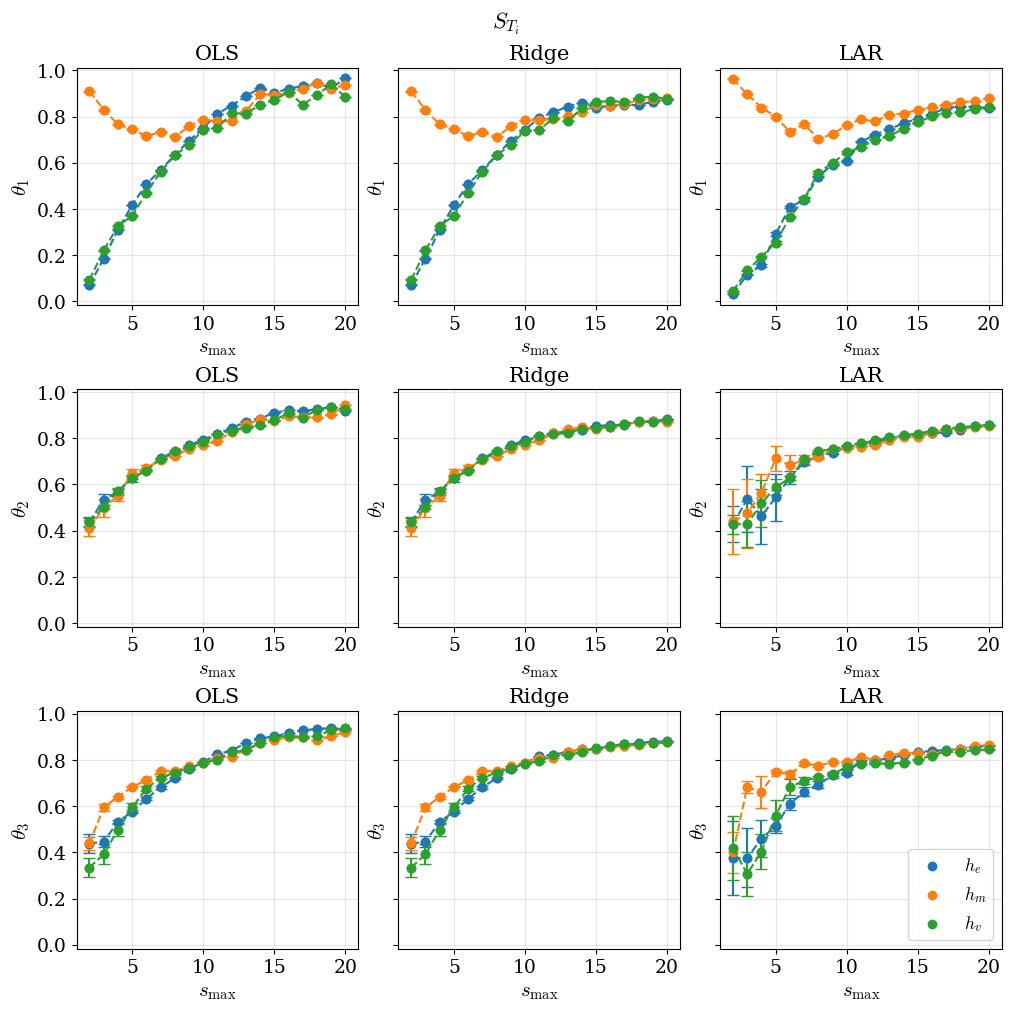

In [36]:
param_names = [r"$h_e$", r"$h_m$", r"$h_v$"]
    
n_d_coord = 3

fig, axs = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True, sharey=True)

for d in range(n_d_coord):
    for i, param in enumerate(param_names):
        axs[d,0].scatter(s_max, r_ols_to_si.mean(axis=0)[:, i, d], label=param)
        axs[d,0].errorbar(s_max, r_ols_to_si.mean(axis=0)[:, i, d],
                          r_ols_to_si.var(axis=0, ddof=1)[:, i, d],
                          linestyle='--', marker='o', capsize=4)
        axs[d,0].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,0].set(title=r"OLS")
        
        axs[d,1].scatter(s_max, r_ridge_to_si.mean(axis=0)[:, i, d], label=param)
        axs[d,1].errorbar(s_max, r_ridge_to_si.mean(axis=0)[:, i, d],
                          r_ridge_to_si.var(axis=0, ddof=1)[:, i, d],
                          linestyle='--', marker='o', capsize=4)
        axs[d,1].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,1].set(title=r"Ridge")
        
        axs[d,2].scatter(s_max, r_LAR_to_si.mean(axis=0)[:, i, d], label=param)
        axs[d,2].errorbar(s_max, r_LAR_to_si.mean(axis=0)[:, i, d],
                          r_LAR_to_si.var(axis=0, ddof=1)[:, i, d],
                          linestyle='--', marker='o', capsize=4)
        axs[d,2].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,2].set(title=r"LAR")
        
plt.legend() 
plt.suptitle(r"$S_{T_i}$")
        
plt.show()

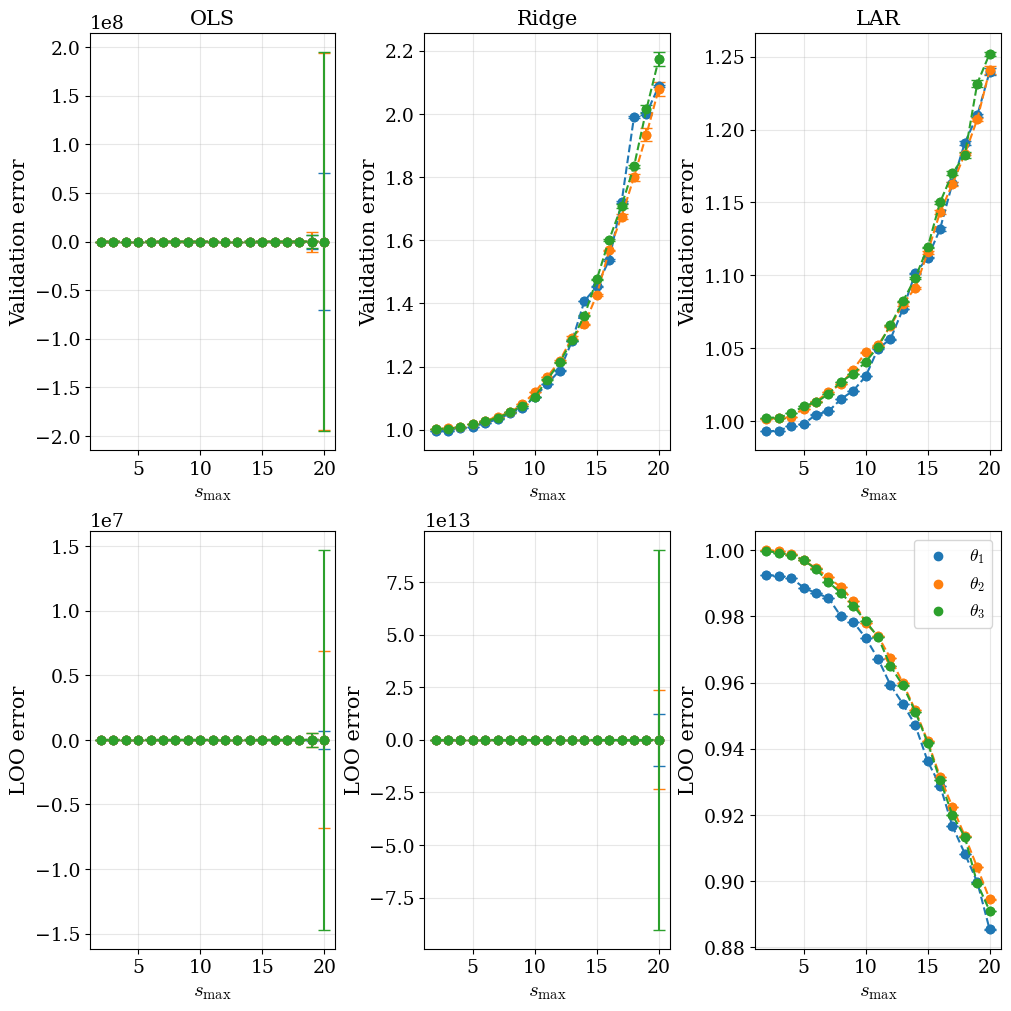

In [37]:
n_dcoords = 3

fig, axs = plt.subplots(2, 3, figsize=(10, 10), constrained_layout=True)

for d in range(n_dcoords):
    
    axs[0,0].scatter(s_max, r_ols_error.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0,0].errorbar(s_max, r_ols_error.mean(axis=0)[:, d],
                      r_ols_error.var(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[1,0].scatter(s_max, r_ols_LOO.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[1,0].errorbar(s_max, r_ols_LOO.mean(axis=0)[:, d],
                      r_ols_LOO.var(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0,0].set(title=r"OLS")
    
    axs[0,1].scatter(s_max, r_ridge_error.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0,1].errorbar(s_max, r_ridge_error.mean(axis=0)[:, d],
                      r_ridge_error.var(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[1,1].scatter(s_max, r_ridge_LOO.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[1,1].errorbar(s_max, r_ridge_LOO.mean(axis=0)[:, d],
                      r_ridge_LOO.var(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0,1].set(title=r"Ridge")
    
    axs[0,2].scatter(s_max, r_LAR_error.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0,2].errorbar(s_max, r_LAR_error.mean(axis=0)[:, d],
                      r_LAR_error.var(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[1,2].scatter(s_max, r_LAR_LOO.mean(axis=0)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[1,2].errorbar(s_max, r_LAR_LOO.mean(axis=0)[:, d],
                      r_LAR_LOO.var(axis=0, ddof=1)[:, d],
                      linestyle='--', marker='o', capsize=4)
    axs[0,2].set(title=r"LAR")
    
    
for i in range(3):
    axs[0,i].set(ylabel=r'Validation error', xlabel=r'$s_{\max}$')
    axs[1,i].set(ylabel=r'LOO error', xlabel=r'$s_{\max}$')

plt.legend()
plt.show()

In [227]:
ranks = []

num_runs = 10

for run in range(num_runs):
    data_all = pop100_lambda34_reshaped[run]
    
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')

Ranks: 
 [[   14 51200]]


In [16]:
data = pop100_lambda34_reshaped[0]

# Perform GDMAps
start_time = time.time()
g, coord, Grass, residuals, index, evals, evecs = GDMaps(data=data, 
                                                         n_evecs=20,
                                                         n_keep=3, 
                                                         p=10,
                                                         parsim=True).get() 

print("--- GDMaps - %s seconds ---" % (time.time() - start_time))

Running with parsimonious representation
--- GDMaps - 659.3780188560486 seconds ---


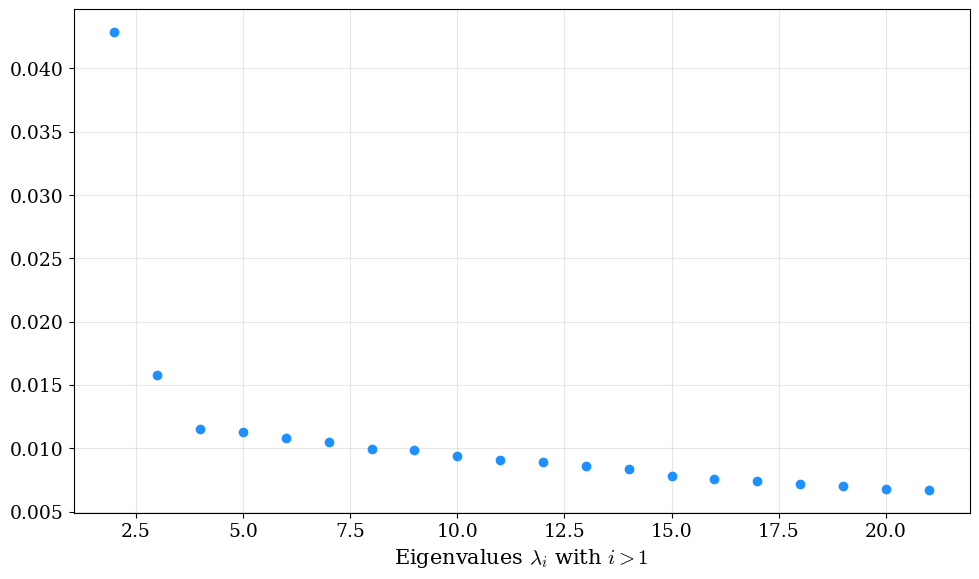

In [17]:
plt.scatter(np.arange(2, len(evals)+1, 1), evals[1:], c='dodgerblue')
plt.xlabel(r'Eigenvalues $\lambda_i$ with $i > 1$')
plt.tight_layout()
plt.show()

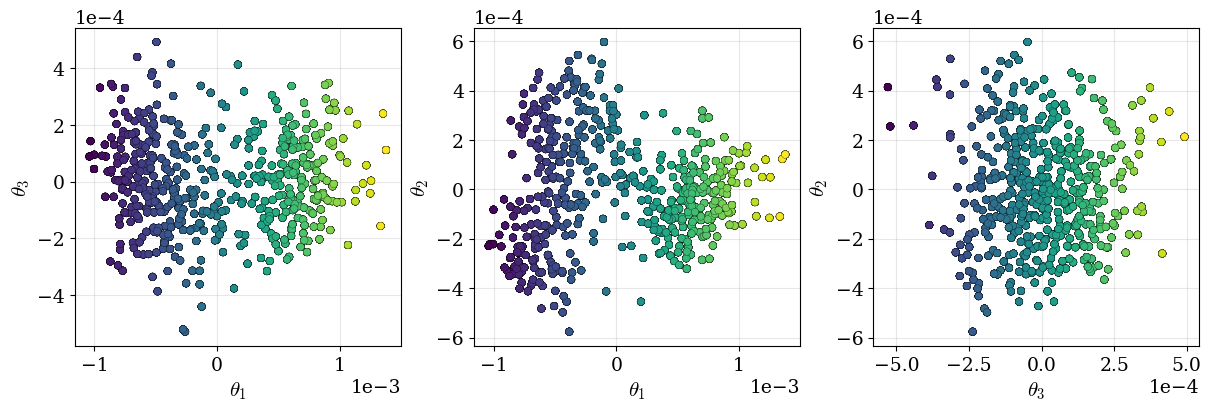

In [18]:
plot_dm_parsim_coord(coord, g)

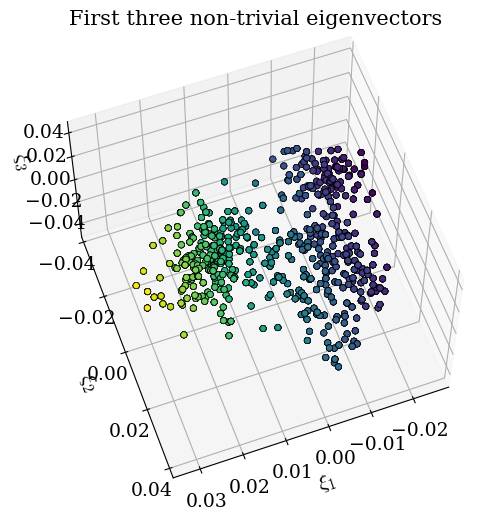

In [19]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(evecs[:, 1], evecs[:, 2], evecs[:, 3],
           cmap='viridis', s=20,
           c=evecs[:, 1],
           edgecolors='k', 
           linewidth=0.5)
ax.set(xlabel=r'$\xi_{1}$', 
       ylabel=r'$\xi_{2}$', 
       zlabel=r'$\xi_{3}$', 
       title='First three non-trivial eigenvectors')
ax.view_init(60, 70)
plt.show()

Size of the full set of PCE basis: 1771
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
[-0.00079493 -0.00015183 -0.00034422]
[3.78137310e-05 2.61575183e-04 7.59589745e-06]


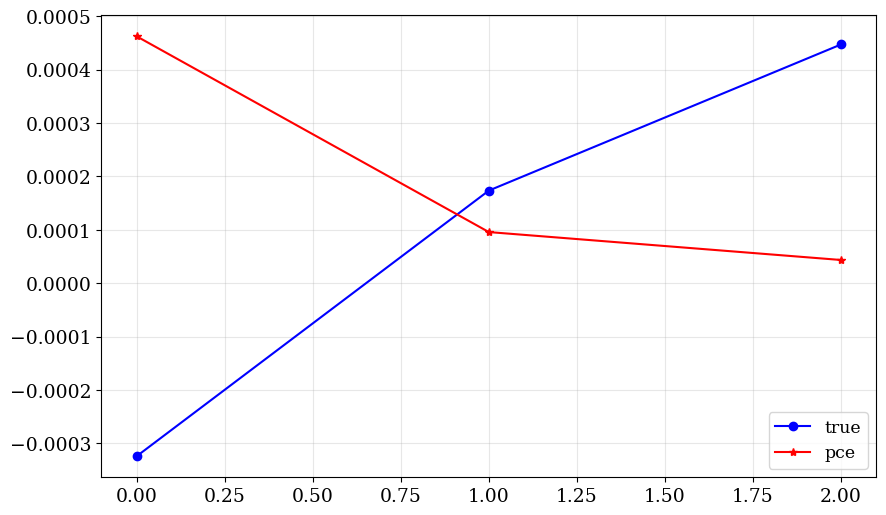

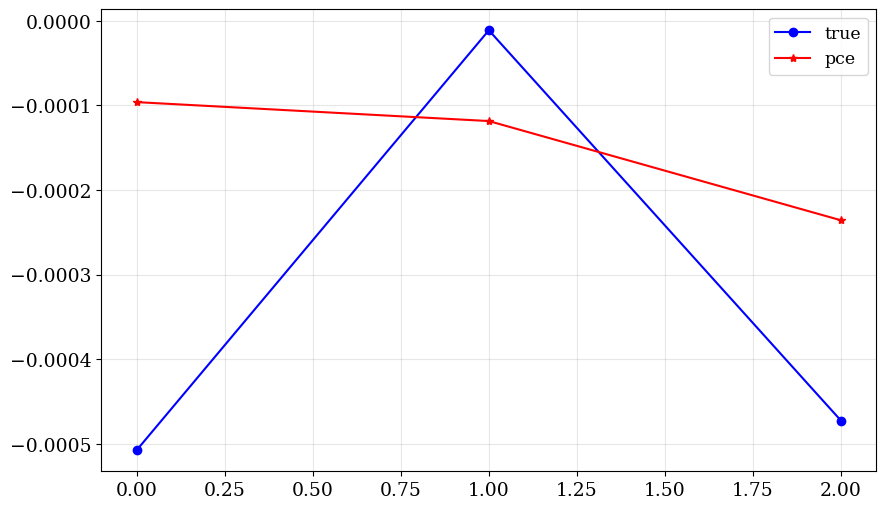

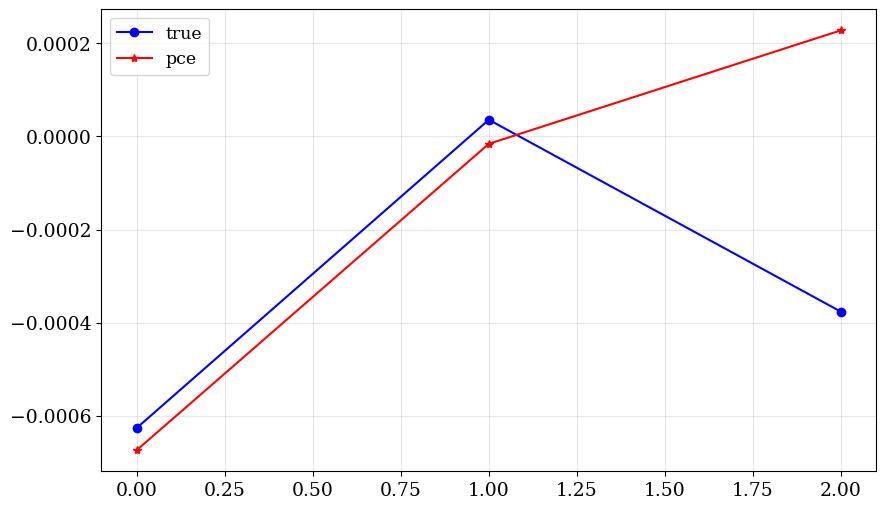

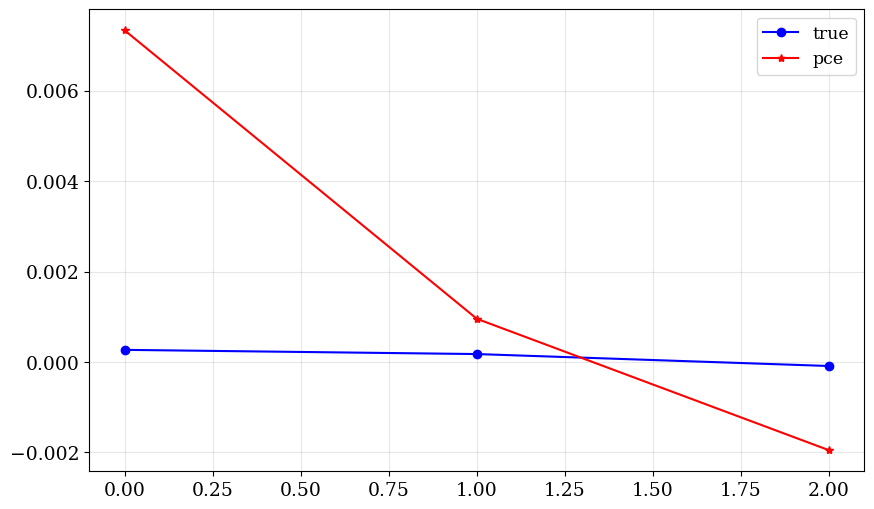

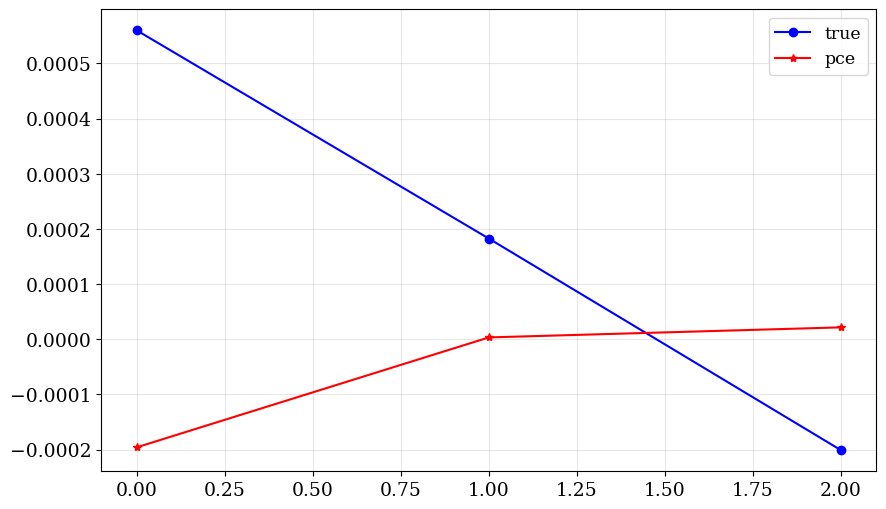

Error of PCE: [30018.9821006  1645.5826486  4619.6836631]
--- Surrogate - 6.896795988082886 seconds ---


In [34]:
x = saltelli_1024

# Perform PCE on the manifold
start_time = time.time()

pce, error = PceModel(x=x, 
                      g=g, 
                      dist_obj=joint, 
                      max_degree=20, 
                      regression='OLS',
                      verbose=True).get()

print('Error of PCE:', error)
print("--- Surrogate - %s seconds ---" % (time.time() - start_time))

In [36]:
pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()

print('First-order Sobol indices:')
print(pce_fo_si)
print('Total-order Sobol indices:')
print(pce_to_si)

First-order Sobol indices:
[[0.00403473 0.0035366  0.000432  ]
 [0.0024429  0.00176122 0.00187595]
 [0.00081664 0.00085689 0.00589913]]
Total-order Sobol indices:
[[0.97263488 0.92171638 0.88658042]
 [0.96806564 0.96382891 0.93266379]
 [0.88765749 0.93348355 0.96810423]]


Size of the full set of PCE basis: 1771
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
[-0.00079493 -0.00015183 -0.00034422]
[2.14866232e-04 2.28063732e-04 2.99788761e-05]


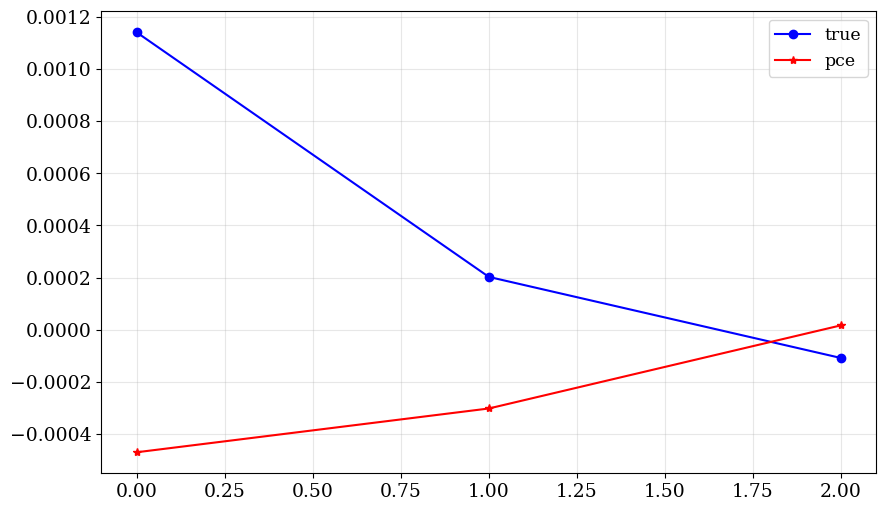

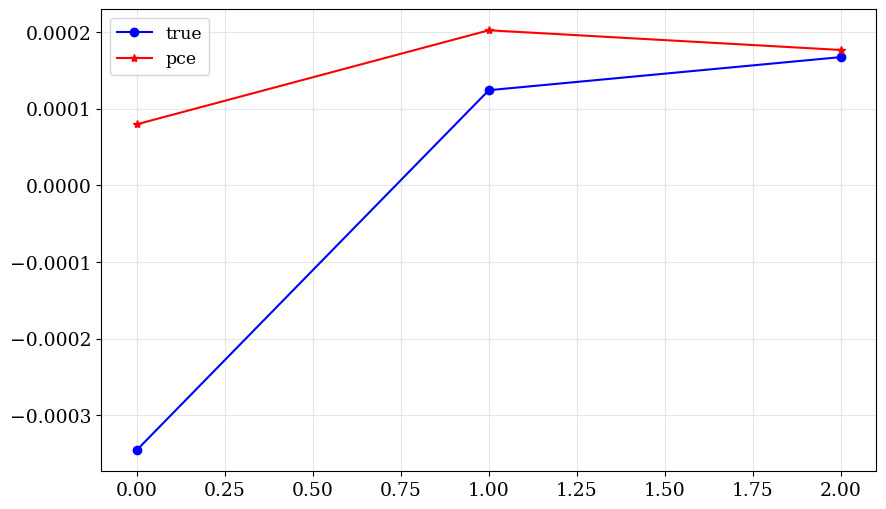

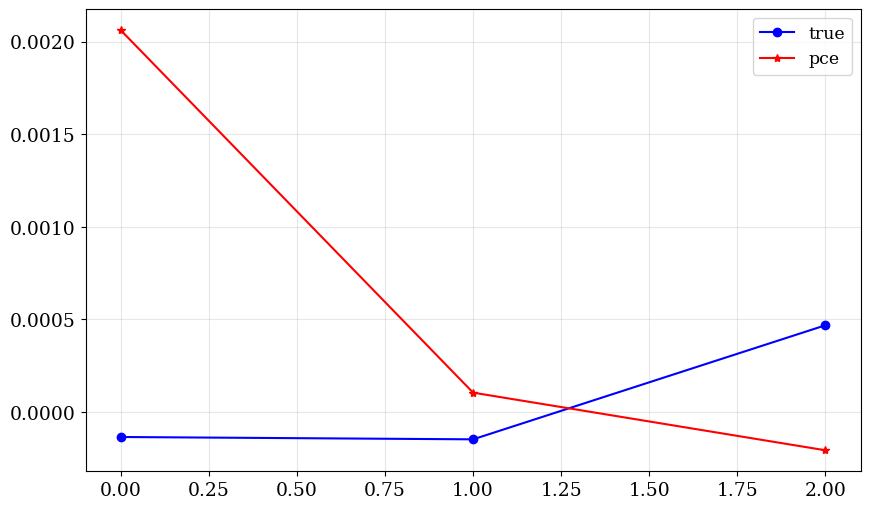

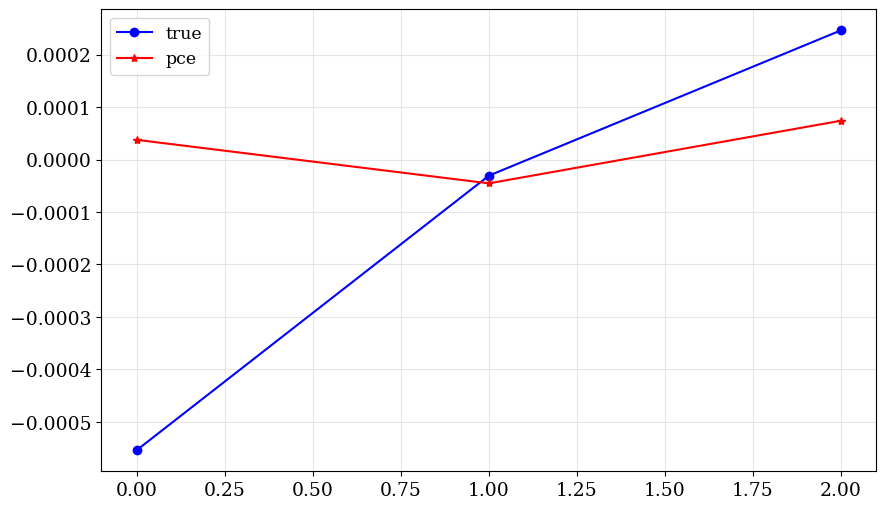

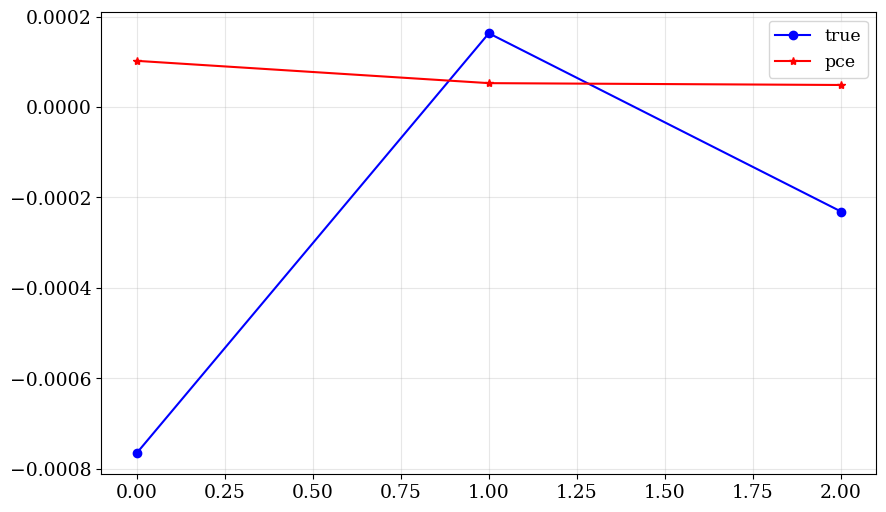

Error of PCE: [2.0228402 2.2917564 2.1651782]
--- Surrogate - 94.28674292564392 seconds ---


In [37]:
x = saltelli_1024

# Perform PCE on the manifold
start_time = time.time()

pce, error = PceModel(x=x, 
                      g=g, 
                      dist_obj=joint, 
                      max_degree=20, 
                      regression='Ridge',
                      verbose=True).get()

print('Error of PCE:', error)
print("--- Surrogate - %s seconds ---" % (time.time() - start_time))

In [38]:
pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()

print('First-order Sobol indices:')
print(pce_fo_si)
print('Total-order Sobol indices:')
print(pce_to_si)

First-order Sobol indices:
[[0.00743387 0.01020623 0.01173081]
 [0.0152687  0.01480594 0.01088322]
 [0.00487334 0.00996104 0.01192317]]
Total-order Sobol indices:
[[0.86742275 0.86442217 0.86975676]
 [0.86916649 0.88715846 0.88837609]
 [0.88400827 0.884684   0.86151073]]


In [39]:
s_max = np.linspace(2, 20, 19, dtype='int')

val_error_ols = []
loo_error_ols = []
pce_fo_si_ols = []
pce_to_si_ols = []

for i, s in enumerate(s_max):
    
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=s, 
                          regression='OLS',
                          verbose=False).get()
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()
    
    val_error_ols.append(error)
    loo_error_ols.append(pce.leaveoneout_error())
    
    pce_fo_si_ols.append(pce_fo_si)
    pce_to_si_ols.append(pce_to_si)
    
    


Size of the full set of PCE basis: 10
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 20
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 35
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 56
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 84
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 120
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 165
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 220
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set 

In [74]:
s_max = np.linspace(2, 20, 19, dtype='int')

val_error_ridge = []
loo_error_ridge = []
pce_fo_si_ridge = []
pce_to_si_ridge = []

for i, s in enumerate(s_max):
    
    pce, error = PceModel(x=x, 
                          g=g, 
                          dist_obj=joint, 
                          max_degree=s, 
                          regression='Ridge',
                          verbose=False).get()
    
    pce_to_si = PceSensitivity(pce).calculate_total_order_indices()
    pce_fo_si = PceSensitivity(pce).calculate_first_order_indices()
    
    val_error_ridge.append(error)
    loo_error_ridge.append(pce.leaveoneout_error())
    
    pce_fo_si_ridge.append(pce_fo_si)
    pce_to_si_ridge.append(pce_to_si)

Size of the full set of PCE basis: 10
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 20
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 35
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 56
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 84
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 120
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 165
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set of PCE basis: 220
Shape of the training set (x)): (3413, 3)
Shape of the training set (y)): (3413, 3)
Size of the full set 

In [221]:
pce_fo_si_ridge[0]

array([[0.06067548, 0.20952952, 0.39088549],
       [0.82473671, 0.17556179, 0.2474285 ],
       [0.0020004 , 0.12208748, 0.01813537]])

In [222]:
pce_fo_si_ridge[0][0]

array([0.06067548, 0.20952952, 0.39088549])

In [218]:
val_error_ridge

[array([0.9917155, 1.0011827, 1.0001822]),
 array([0.9931863, 1.0022227, 1.0002112]),
 array([1.0034031, 1.0000849, 1.0073645]),
 array([1.0096885, 1.0134579, 1.0179515]),
 array([1.0264018, 1.0269325, 1.0271121]),
 array([1.0396751, 1.0409234, 1.041263 ]),
 array([1.0547437, 1.048382 , 1.0579691]),
 array([1.0753359, 1.1051173, 1.0794978]),
 array([1.1062621, 1.157469 , 1.106646 ]),
 array([1.164223 , 1.1652275, 1.1738956]),
 array([1.1815109, 1.3100272, 1.2362321]),
 array([1.2826282, 1.4470642, 1.2714713]),
 array([1.4109302, 1.387406 , 1.3740069]),
 array([1.4637721, 1.4725266, 1.4501767]),
 array([1.501867 , 1.5875052, 1.6049188]),
 array([1.6840818, 1.686493 , 1.7853421]),
 array([1.9767381, 1.8262223, 1.9030874]),
 array([1.9102203, 2.0214343, 2.0689728]),
 array([2.0228402, 2.2917564, 2.1651782])]

In [196]:
def PCE_LAR_model_selection(x, g, n_params, dist_obj, max_degree):
  
    n_dcoords = g.shape[1]
    
    # construct total-degree polynomial basis
    polynomial_basis = TotalDegreeBasis(joint, max_degree)

    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    xx_train, xx_test, \
        gg_train, gg_test = train_test_split(x, g, train_size=2 / 3, random_state=1)

    error_pce = np.zeros((n_dcoords))
    pce_fo_si = np.zeros((n_params, n_dcoords))
    pce_to_si = np.zeros((n_params, n_dcoords))

    error_pceLAR = np.zeros((n_dcoords))
    MAE_pceLAR   = np.zeros((n_dcoords))
    LOO_pceLAR   = np.zeros((n_dcoords))
    pceLAR_fo_si = np.zeros((n_params, n_dcoords))
    pceLAR_to_si = np.zeros((n_params, n_dcoords))

    for i in range(3):
        print('Theta',i)
        
        pce.fit(xx_train, gg_train[:, i])

        error_pce[i] = ErrorEstimation(surr_object=pce).validation(xx_test, gg_test[:, i])

        # sensitivity from PCE
        pce_sensitivity = PceSensitivity(pce)
        pce_sensitivity.run()

        sobol_first = pce_sensitivity.first_order_indices
        sobol_total = pce_sensitivity.total_order_indices

        pce_fo_si[:, i] = sobol_first.T
        pce_to_si[:, i] = sobol_total.T

        # Lars model selection
        print('Size of the full set of PCE basis:', polynomial_basis.polynomials_number)

        target_error = 1
        CheckOverfitting = True
        pceLAR = polynomial_chaos.regressions.LeastAngleRegression.model_selection(pce, 
                                                                                   target_error, 
                                                                                   CheckOverfitting)

        print('Size of the LAR PCE basis:', pceLAR.polynomial_basis.polynomials_number)

        n_samples_val = len(xx_test)
        gg_test_pce = pceLAR.predict(xx_test).flatten()
        errors = np.abs(gg_test[:, i].flatten() - gg_test_pce)
        MAE = (np.linalg.norm(errors, 1) / n_samples_val)

        error_pceLAR[i] = ErrorEstimation(surr_object=pceLAR).validation(xx_test, gg_test[:, i])
        MAE_pceLAR[i]   = MAE               
        LOO_pceLAR[i]   = pceLAR.leaveoneout_error()

        print('Mean absolute error:', MAE)
        print('Leave-one-out cross validation on ED:', pceLAR.leaveoneout_error())

        pceLAR_sensitivity = PceSensitivity(pceLAR)
        pceLAR_sensitivity.run()

        LAR_sobol_first = pceLAR_sensitivity.first_order_indices
        LAR_sobol_total = pceLAR_sensitivity.total_order_indices

        pceLAR_fo_si[:, i] = LAR_sobol_first.T
        pceLAR_to_si[:, i] = LAR_sobol_total.T
        
    return (error_pce, pce_fo_si, pce_to_si,
            error_pceLAR, MAE_pceLAR, LOO_pceLAR, pceLAR_fo_si, pceLAR_to_si)
    

In [177]:
LAR_result = PCE_LAR_model_selection(x=x, 
                                     g=g, 
                                     n_params=3, 
                                     dist_obj=joint, 
                                     max_degree=17)

0
Theta 0
Size of the full set of PCE basis: 1140
Size of the LAR PCE basis: 173
Mean absolute error: 0.0005518030475083839
Leave-one-out cross validation on ED: 0.9169789
1
Theta 1
Size of the full set of PCE basis: 1140
Size of the LAR PCE basis: 164
Mean absolute error: 0.000136272550923162
Leave-one-out cross validation on ED: 0.9227586
2
Theta 2
Size of the full set of PCE basis: 1140
Size of the LAR PCE basis: 214
Mean absolute error: 0.00019111812743336342
Leave-one-out cross validation on ED: 0.9304268


In [202]:
s_max = np.linspace(2, 20, 19, dtype='int')

val_error_LAR = []
MAE_error_LAR = []
loo_error_LAR = []
pce_fo_si_LAR = []
pce_to_si_LAR = []

for i, s in enumerate(s_max):
    
    LAR_result = PCE_LAR_model_selection(x=x, 
                                         g=g, 
                                         n_params=3, 
                                         dist_obj=joint, 
                                         max_degree=s)
    
    val_error_LAR.append(LAR_result[3])
    MAE_error_LAR.append(LAR_result[4])
    loo_error_LAR.append(LAR_result[5])
    
    pce_fo_si_LAR.append(LAR_result[6])
    pce_to_si_LAR.append(LAR_result[7])

Theta 0
Size of the full set of PCE basis: 10
Size of the LAR PCE basis: 4
Mean absolute error: 0.0005363568703667006
Leave-one-out cross validation on ED: 0.9923443
Theta 1
Size of the full set of PCE basis: 10
Size of the LAR PCE basis: 5
Mean absolute error: 0.00012380813584119595
Leave-one-out cross validation on ED: 0.9991805
Theta 2
Size of the full set of PCE basis: 10
Size of the LAR PCE basis: 3
Mean absolute error: 0.00017697317295305325
Leave-one-out cross validation on ED: 1.000135
Theta 0
Size of the full set of PCE basis: 20
Size of the LAR PCE basis: 4
Mean absolute error: 0.0005363568703667006
Leave-one-out cross validation on ED: 0.9923443
Theta 1
Size of the full set of PCE basis: 20
Size of the LAR PCE basis: 5
Mean absolute error: 0.00012380813584119595
Leave-one-out cross validation on ED: 0.9991805
Theta 2
Size of the full set of PCE basis: 20
Size of the LAR PCE basis: 5
Mean absolute error: 0.00017714513833561805
Leave-one-out cross validation on ED: 0.9999644
T

Size of the full set of PCE basis: 1330
Size of the LAR PCE basis: 217
Mean absolute error: 0.00013763937536356236
Leave-one-out cross validation on ED: 0.9198942
Theta 2
Size of the full set of PCE basis: 1330
Size of the LAR PCE basis: 179
Mean absolute error: 0.0001889633171765514
Leave-one-out cross validation on ED: 0.9238298
Theta 0
Size of the full set of PCE basis: 1540
Size of the LAR PCE basis: 265
Mean absolute error: 0.0005609549924399471
Leave-one-out cross validation on ED: 0.8953312
Theta 1
Size of the full set of PCE basis: 1540
Size of the LAR PCE basis: 221
Mean absolute error: 0.0001378992300165823
Leave-one-out cross validation on ED: 0.9069479
Theta 2
Size of the full set of PCE basis: 1540
Size of the LAR PCE basis: 304
Mean absolute error: 0.0001966323953208967
Leave-one-out cross validation on ED: 0.9084692
Theta 0
Size of the full set of PCE basis: 1771
Size of the LAR PCE basis: 306
Mean absolute error: 0.0005664184330908383
Leave-one-out cross validation on E

In [219]:
pce_fo_si_LAR 

[array([[0.06409073, 0.1893284 , 0.59018043],
        [0.86290685, 0.20715627, 0.        ],
        [0.        , 0.        , 0.        ]]),
 array([[0.06409073, 0.1893284 , 0.29185844],
        [0.86290685, 0.20715627, 0.26566376],
        [0.        , 0.        , 0.        ]]),
 array([[0.05807592, 0.35730003, 0.16049045],
        [0.75280945, 0.16264638, 0.14404665],
        [0.07122631, 0.        , 0.33697701]]),
 array([[0.03461691, 0.12785134, 0.10287633],
        [0.60740899, 0.04890926, 0.082741  ],
        [0.05212205, 0.12847856, 0.22523834]]),
 array([[0.02598127, 0.21686198, 0.06872142],
        [0.52486025, 0.07543818, 0.05109096],
        [0.04077154, 0.0841095 , 0.33494009]]),
 array([[0.02573351, 0.15529704, 0.03749291],
        [0.50379496, 0.05491361, 0.02747725],
        [0.04159849, 0.07048415, 0.19204559]]),
 array([[0.01505311, 0.13528759, 0.04266107],
        [0.36905551, 0.04851653, 0.06151192],
        [0.027966  , 0.07130458, 0.14747608]]),
 array([[0.01442703,

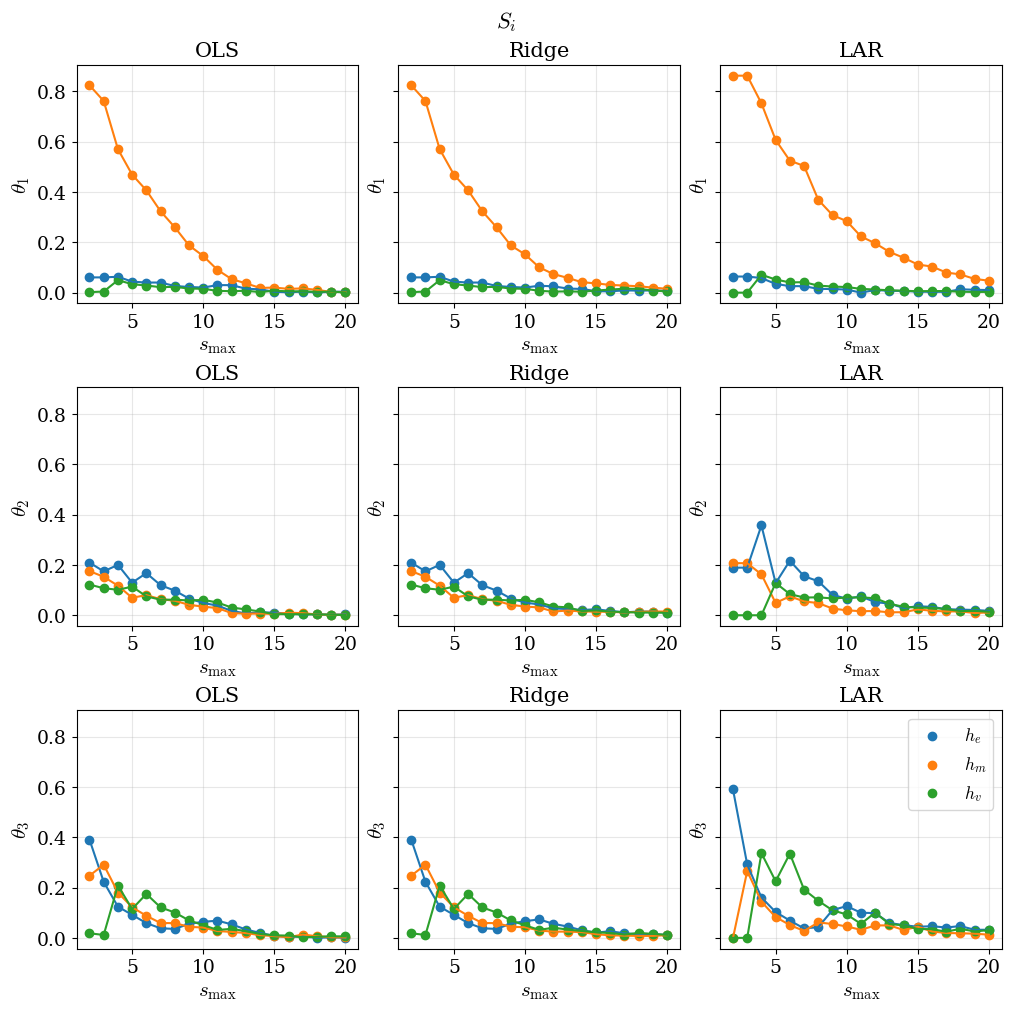

In [208]:
param_names = [r"$h_e$", r"$h_m$", r"$h_v$"]
    
n_d_coord = 3

fig, axs = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True, sharey=True)

for d in range(n_d_coord):
    for i, param in enumerate(param_names):
        axs[d,0].scatter(s_max, np.asarray(pce_fo_si_ols)[:, i, d], label=param)
        axs[d,0].plot(s_max, np.asarray(pce_fo_si_ols)[:, i, d])
        axs[d,0].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,0].set(title=r"OLS")
        
        axs[d,1].scatter(s_max, np.asarray(pce_fo_si_ridge)[:, i, d], label=param)
        axs[d,1].plot(s_max, np.asarray(pce_fo_si_ridge)[:, i, d])
        axs[d,1].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,1].set(title=r"Ridge")
        
        axs[d,2].scatter(s_max, np.asarray(pce_fo_si_LAR)[:, i, d], label=param)
        axs[d,2].plot(s_max, np.asarray(pce_fo_si_LAR)[:, i, d])
        axs[d,2].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,2].set(title=r"LAR")
        
plt.legend() 
plt.suptitle(r"$S_{i}$")
        
plt.show()

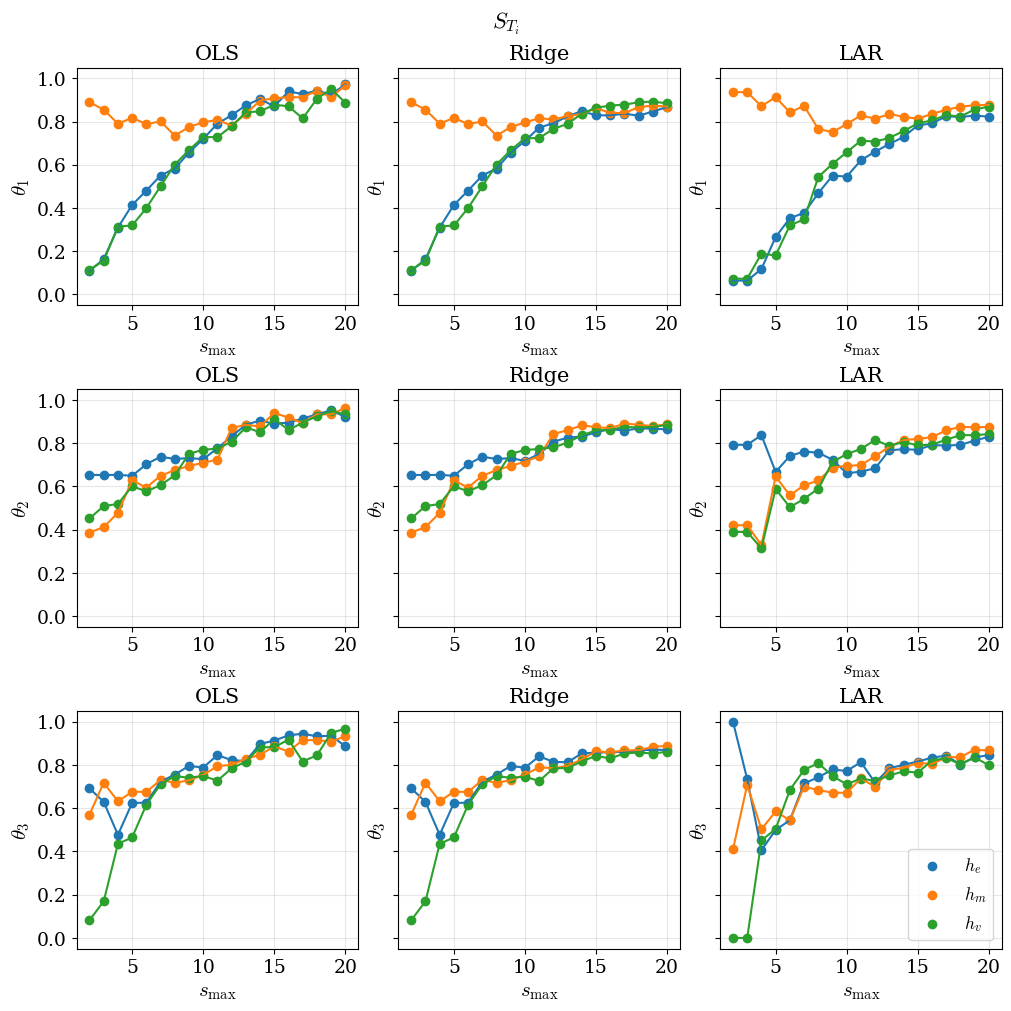

In [207]:
param_names = [r"$h_e$", r"$h_m$", r"$h_v$"]
    
n_d_coord = 3


fig, axs = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True, sharey=True)


for d in range(n_d_coord):
    for i, param in enumerate(param_names):
        axs[d,0].scatter(s_max, np.asarray(pce_to_si_ols)[:, i, d], label=param)
        axs[d,0].plot(s_max, np.asarray(pce_to_si_ols)[:, i, d])
        axs[d,0].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,0].set(title=r"OLS")

        axs[d,1].scatter(s_max, np.asarray(pce_to_si_ridge)[:, i, d], label=param)
        axs[d,1].plot(s_max, np.asarray(pce_to_si_ridge)[:, i, d])
        axs[d,1].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,1].set(title=r"Ridge")
        
        axs[d,2].scatter(s_max, np.asarray(pce_to_si_LAR)[:, i, d], label=param)
        axs[d,2].plot(s_max, np.asarray(pce_to_si_LAR)[:, i, d])
        axs[d,2].set(ylabel=r"$\theta_{d}$".format(d=d+1),xlabel=r"$s_{\max}$")
        axs[d,2].set(title=r"LAR")
        
plt.legend() 
plt.suptitle(r"$S_{T_i}$")
        
plt.show()

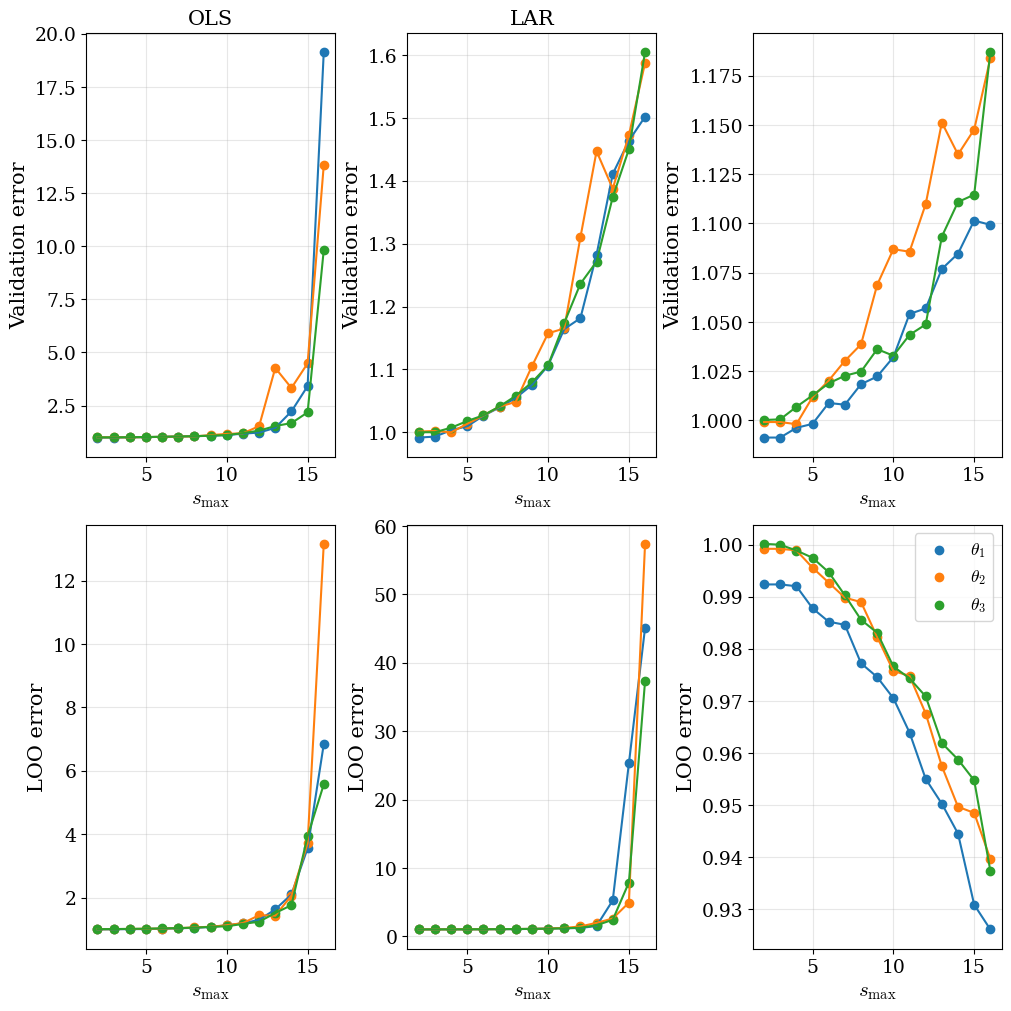

In [216]:
n_dcoords = 3

fig, axs = plt.subplots(2, 3, figsize=(10, 10), constrained_layout=True)

for d in range(n_dcoords):
    
    axs[0,0].scatter(s_max[:15], np.asarray(val_error_ols)[:, d][:15], label=r"$\theta_{d}$".format(d=d+1))
    axs[0,0].plot(s_max[:15], np.asarray(val_error_ols)[:, d][:15])
    axs[1,0].scatter(s_max[:15], np.asarray(loo_error_ols)[:, d][:15], label=r"$\theta_{d}$".format(d=d+1))
    axs[1,0].plot(s_max[:15], np.asarray(loo_error_ols)[:, d][:15])
    axs[0,0].set(title=r"OLS")
    
    axs[0,1].scatter(s_max[:15], np.asarray(val_error_ridge)[:, d][:15], label=r"$\theta_{d}$".format(d=d+1))
    axs[0,1].plot(s_max[:15], np.asarray(val_error_ridge)[:, d][:15])
    axs[1,1].scatter(s_max[:15], np.asarray(loo_error_ridge)[:, d][:15], label=r"$\theta_{d}$".format(d=d+1))
    axs[1,1].plot(s_max[:15], np.asarray(loo_error_ridge)[:, d][:15])
    axs[0,1].set(title=r"Ridge")
    
    axs[0,2].scatter(s_max[:15], np.asarray(val_error_LAR)[:, d][:15], label=r"$\theta_{d}$".format(d=d+1))
    axs[0,2].plot(s_max[:15], np.asarray(val_error_LAR)[:, d][:15])
    axs[1,2].scatter(s_max[:15], np.asarray(loo_error_LAR)[:, d][:15], label=r"$\theta_{d}$".format(d=d+1))
    axs[1,2].plot(s_max[:15], np.asarray(loo_error_LAR)[:, d][:15])
    axs[0,1].set(title=r"LAR")
    
    
for i in range(3):
    axs[0,i].set(ylabel=r'Validation error', xlabel=r'$s_{\max}$')
    axs[1,i].set(ylabel=r'LOO error', xlabel=r'$s_{\max}$')

plt.legend()
plt.show()

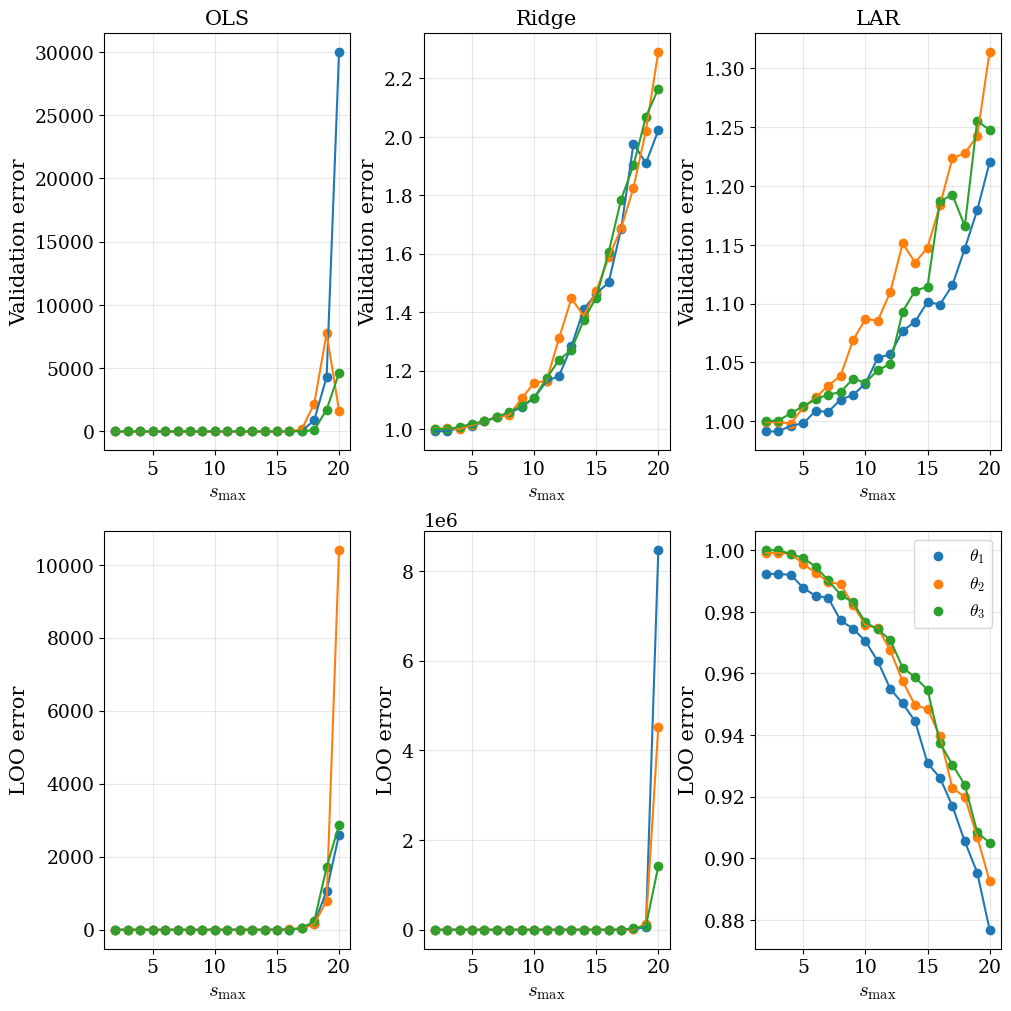

In [213]:
n_dcoords = 3

fig, axs = plt.subplots(2, 3, figsize=(10, 10), constrained_layout=True)

for d in range(n_dcoords):
    
    axs[0,0].scatter(s_max, np.asarray(val_error_ols)-, label=r"$\theta_{d}$".format(d=d+1))
    axs[0,0].plot(s_max, np.asarray(val_error_ols)[:, d])
    axs[1,0].scatter(s_max, np.asarray(loo_error_ols)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[1,0].plot(s_max, np.asarray(loo_error_ols)[:, d])
    axs[0,0].set(title=r"OLS")
    
    axs[0,1].scatter(s_max, np.asarray(val_error_ridge)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0,1].plot(s_max, np.asarray(val_error_ridge)[:, d])
    axs[1,1].scatter(s_max, np.asarray(loo_error_ridge)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[1,1].plot(s_max, np.asarray(loo_error_ridge)[:, d])
    axs[0,1].set(title=r"Ridge")
    
    axs[0,2].scatter(s_max, np.asarray(val_error_LAR)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[0,2].plot(s_max, np.asarray(val_error_LAR)[:, d])
    axs[1,2].scatter(s_max, np.asarray(loo_error_LAR)[:, d], label=r"$\theta_{d}$".format(d=d+1))
    axs[1,2].plot(s_max, np.asarray(loo_error_LAR)[:, d])
    axs[0,2].set(title=r"LAR")
    
    
for i in range(3):
    axs[0,i].set(ylabel=r'Validation error', xlabel=r'$s_{\max}$')
    axs[1,i].set(ylabel=r'LOO error', xlabel=r'$s_{\max}$')

plt.legend()
plt.show()

In [214]:
loo_error_LAR

[array([0.9923443, 0.9991805, 1.000135 ]),
 array([0.9923443, 0.9991805, 0.9999644]),
 array([0.9920065, 0.9988816, 0.9988498]),
 array([0.9877643, 0.9955556, 0.9974695]),
 array([0.9851907, 0.9926912, 0.994683 ]),
 array([0.9846005, 0.989808 , 0.9902669]),
 array([0.9772124, 0.9889521, 0.9855655]),
 array([0.9745634, 0.9822608, 0.9830605]),
 array([0.9705135, 0.9757332, 0.9765975]),
 array([0.9639223, 0.9748036, 0.974323 ]),
 array([0.955019 , 0.9675694, 0.9708573]),
 array([0.9502561, 0.9574635, 0.9619043]),
 array([0.9445189, 0.9496686, 0.9587455]),
 array([0.9308803, 0.948502 , 0.9547421]),
 array([0.9261368, 0.9396676, 0.9373755]),
 array([0.9169789, 0.9227586, 0.9304268]),
 array([0.9054527, 0.9198942, 0.9238298]),
 array([0.8953312, 0.9069479, 0.9084692]),
 array([0.8767859, 0.892574 , 0.9049794])]

In [215]:
MAE_error_LAR

[array([0.00053636, 0.00012381, 0.00017697]),
 array([0.00053636, 0.00012381, 0.00017715]),
 array([0.0005373 , 0.00012369, 0.00017751]),
 array([0.00053717, 0.00012462, 0.00017792]),
 array([0.00054003, 0.00012541, 0.00017868]),
 array([0.00053929, 0.00012592, 0.00017868]),
 array([0.00054119, 0.00012653, 0.00017885]),
 array([0.00054031, 0.0001284 , 0.00018001]),
 array([0.00054279, 0.00012945, 0.00017946]),
 array([0.00054695, 0.00012942, 0.00018056]),
 array([0.00054553, 0.0001303 , 0.00018037]),
 array([0.00054935, 0.00013254, 0.00018458]),
 array([0.00055061, 0.00013197, 0.00018588]),
 array([0.00055316, 0.00013243, 0.00018653]),
 array([0.00055153, 0.00013424, 0.0001913 ]),
 array([0.0005518 , 0.00013627, 0.00019112]),
 array([0.00055941, 0.00013764, 0.00018896]),
 array([0.00056095, 0.0001379 , 0.00019663]),
 array([0.00056642, 0.00014156, 0.00019687])]